# Overview
In this notebook, I study entity normalization and make hashmaps for normalized term look-up. I also code search functions to extract related text information for further/other investigations.

- **Note**: Chapter & section numbers mentioned here are visible by activating "Table of Content" in [nb-Extension](https://anaconda.org/conda-forge/jupyter_contrib_nbextensions) of Jupyter notebook

Author: Yungkwon Kim (yungkwon.kim@)

## Tasks
- Extract entities from the initial corpus in project *MoneyFlow*
- Text Normalization for entitiy names of *persons*, *countries*, *locations* and *companies*, respectively
- Use several matching algorithms and try ensemble methods with per-type weighting schemes
- Use a graph algorithm to find connected components for candidates to sync
- Gegerate/Save look-up hashmaps (i.e. Python-dictionaries) with (key, value) = (*text_in_snippet*, *normalized_term*) and *vice versa.*

(ToDo)
- Anotate result to gather training data followed by ML to learn weights

## Version history
(0.3.5 &rarr; 0.3.6):
 - Collection update ( **"Corpus Clean1"** &rarr; **"Corpus Clean2"**)
 - Check and handle prefixes for *Person* names (e.g. 'President Obama' = 'Obama'). See section (4.1.3), (4.1.5), (4.1.7).
 - Remove Country-name-normalization since *Location names* includes *Country names*.

(0.3.4 &rarr; 0.3.5):
- Collection update (**"Corpus D -KEC"** &rarr; **"Corpus Clean1"**)
- Code change to adjust to the changes of preprocessing structure in a new Collection e.g. co-document ratio now uses "filename" instead of "document_id" to indentify source documents.
- Bugfixes (section 8.1): Calibrating Rules to choose normalize term. Added *Levenshtein Median* as an option.
- Fixed postprocessing/linking components for company names (e.g. "Huawei" etc.)
- Modulized postprocessing (section 4.3.2)

(0.3.3 &rarr; 0.3.4):
- Added normalization for *'Location'* (See 5.4)
- Improve **"get_simliar_names_by_tfdif()"** by adding **"remove_duplicated_match()"** (See 4.1.3). This is a bug-fix so that ('U.S.", "u.s") pair is now captured as a candidate to match. The former duplicate-removal process removed such a pair while de-duping by simliarity scores (See previous version < 0.3.3 for more details).
- Added an API intergrating component (**"normalize_term()"** in 6.2) 
- Added a rule-based system to choose *proper* normalized term (See 4.3.3)

(0.3.2 &rarr; 0.3.3):
- Use different preprocessing (**"Corpus D"** &rarr; **"Corpus D -KEC"** having over 60K segments now)
- Modified **"make_norm_dict()"** to return *two* outputs - *raw2normalized* & *normalized2raw* (See section 4.3.3)
- Chose the last name in the connected component as the normalied name (See section 4.3.3)
- Added How to Integrate Normalization Layer (See Chapter 6)
- Added normalization for *'Location'* (See 5.4)

(0.3.1 &rarr; 0.3.2):
- Modified following functions to address abbreviation(acronym) and partial match: 'normalize_unicode_to_ascii()', 'fisrt_letter()', 'get_1st_letters_match()'

(0.3.0 &rarr; 0.3.1):
- Optout wiki-matching (too slow for larger dataset - will explore any more efficient alg later)
- Apply a weaker filter for Sub-level TFIDF cos-similarity (cos-sim 1.0 does not necessarily implies that two term are identical)

(0.2.0 &rarr; 0.3.0):
- Dealing with all segments in "discovery_r3" (over 30K segments)
- Handling entity subtypes
- Added nonliear doulbe-metaphone matching scores
- Added inverse-Levenshtein distance
- Toggle sorting for First-letter matching (*on*: "persons", *off*: "countries" & "companies")
- Apply different weighting scheme of mulitple matchig algorithms for different entity types
- Added choice-method for normalized terms

(0.1.1 &rarr; 0.2.0):
- Reorganized structure
- Added various matching layers
- Added graph-algoritm to extract connected components

(0.1.0 &rarr; 0.1.1):
- Changed dataset ([discovery_ai data](https://cloud.ibm.com/services/discovery/crn%3Av1%3Abluemix%3Apublic%3Adiscovery%3Aus-south%3Aa%2F7ac60e065455f98bf3f2979741616102%3A8d5dfb02-b30e-44ee-9a9b-8129af900f10%3A%3A?paneId=manage) &rarr; [discovery_r3 data](https://cloud.ibm.com/services/discovery/crn%3Av1%3Abluemix%3Apublic%3Adiscovery%3Aus-east%3Aa%2F7ac60e065455f98bf3f2979741616102%3Af2df1dc1-c923-49c1-80f3-7e23fc0441e8%3A%3A?paneId=manage))


## Background knowledge
 - [Levenshtein distance](https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html)
 - [Jaro-Winkler distance](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance)
 - [double-metaphone](https://pypi.org/project/Metaphone/)
 - [Database of Chinese name variants](http://www.cjk.org/cjk/samples/cnamevar.htm)

# Modules

In [25]:
from ibm_watson import DiscoveryV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [26]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import json
import math
import copy
import random
from collections import defaultdict, Counter, OrderedDict
from itertools import combinations
import unicodedata
import re
import matplotlib.pyplot as plt
import pickle

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
import wikipedia as wiki
import Levenshtein as lvst
from metaphone import doublemetaphone as dmt_phone
import networkx as nx
import nxviz as nv
from sparse_dot_topn import awesome_cossim_topn as cossim_topn

In [29]:
import spacy
from spacy import displacy
from spacy.symbols import nsubj, VERB, NOUN
from spacy.tokens import Doc, Token, Span
from spacy.attrs import ENT_IOB, ENT_TYPE
from spacy.tokenizer import Tokenizer

In [30]:
nlp = spacy.load("en_core_web_sm")

# Data

In [930]:
ver_string = '_v036'

## Loading

In [34]:
# Global variables
version = '2018-08-01'

authenticator_ai = IAMAuthenticator(apikey="8PTX1TRAxjrD_pj7CcNBEcrWhEKX-y8TuGLFIdYvBJB_")
authenticator_r3 = IAMAuthenticator(apikey="e60nrAsq6WIQmWfuzv9_8by2yCXinHK_FOe3u9MSI1ml")

service_url_ai = 'https://api.us-south.discovery.watson.cloud.ibm.com/instances/8d5dfb02-b30e-44ee-9a9b-8129af900f10'
service_url_r3 = 'https://api.us-east.discovery.watson.cloud.ibm.com/instances/f2df1dc1-c923-49c1-80f3-7e23fc0441e8'

#collection_name = 'Corpus D'
#collection_name = 'Corpus D -KEC'
#collection_name = 'Corpus Clean1'
collection_name = 'Corpus Clean2'

In [35]:
# Initialize IBM Discovery instance
def initialize_discovery_dallas(collection_name=''):
    print("=== USING DALLAS LOCATION ===")

    # In the constructor, letting the SDK manage the token
    discovery = DiscoveryV1(version=version,
                            authenticator=authenticator_ai)
    discovery.set_service_url(service_url_ai)

    # get the environment id
    environments = json.dumps(discovery.list_environments().get_result())
    environments = json.loads(environments)
    print("ENVIONEMNTS: ", environments)
    environment_id = environments['environments'][1]['environment_id']

    # get the collections
    collections = json.dumps(discovery.list_collections(environment_id).get_result(), indent=2)
    collections = json.loads(collections)

    # iterate through collections in Discovery
    print("======================= AVAILABLE COLLECTIONS IN CORPUS =======================")
    for collection in collections['collections']:
        print('COLLECTION ID:', collection['collection_id'], 'COLLECTION NAME:', collection['name'])

        # find the collection the user wants, and extract the collection_id
        if str(collection['name']) == collection_name:
            collection_id = collection['collection_id']
        else:
            # raise Exception('ERROR: COLLECTION NAME %s DOES NOT EXIST.' % collection_name)
            pass

    print("--- USING COLLECTION ID: %s " % collection_id)

    return discovery, environment_id, collection_id

In [36]:
def initialize_discovery_washington(collection_name=''):  # connect to discovery_r3 instance (Washington)

    print("=== USING WASHINGTON LOCATION ===")

    # In the constructor, letting the SDK manage the token
    discovery = DiscoveryV1(version=version,
                            authenticator=authenticator_r3)

    discovery.set_service_url(service_url_r3)
    # get the environment id
    environments = json.dumps(discovery.list_environments().get_result())
    environments = json.loads(environments)
    print("ENVIONEMNTS: ", environments)
    environment_id = environments['environments'][1]['environment_id']

    # get the collections
    collections = json.dumps(discovery.list_collections(environment_id).get_result(), indent=2)
    collections = json.loads(collections)

    # iterate through collections in Discovery
    print("======================= AVAILABLE COLLECTIONS IN CORPUS =======================")
    for collection in collections['collections']:
        print('COLLECTION ID:', collection['collection_id'], 'COLLECTION NAME:', collection['name'])

        # find the collection the user wants, and extract the collection_id
        if str(collection['name']) == collection_name:
            collection_id = collection['collection_id']
        else:
            # raise Exception('ERROR: COLLECTION NAME %s DOES NOT EXIST.' % collection_name)
            pass

    print("--- USING COLLECTION ID: %s " % collection_id)

    return discovery, environment_id, collection_id

In [37]:
def download_corpus(discovery, env_id, col_id, count=100, agg_semantic=None, offset=0, query=None):
    
    result = discovery.query(env_id, col_id, filter=None, query=query, natural_language_query=None,
                             passages=False, aggregation=agg_semantic, return_fields=None,
                             offset=offset,
                             sort=None, highlight=True, passages_fields=None,
                             passages_characters=None, deduplicate=False, deduplicate_field=None,
                             collection_ids=None,
                             similar=None, similar_document_ids=None, similar_fields=None, bias=None,
                             logging_opt_out=None, count=count).get_result()
    
    return result

In [38]:
discovery, env_id, col_id = initialize_discovery_washington(collection_name)

=== USING WASHINGTON LOCATION ===
ENVIONEMNTS:  {'environments': [{'environment_id': 'system', 'name': 'Watson System Environment', 'description': 'Shared system data sources', 'read_only': True}, {'environment_id': 'b553004f-6918-473a-8e2a-58e11770c016', 'name': 'byod', 'description': '', 'created': '2020-02-03T19:20:17.665Z', 'updated': '2020-02-03T19:20:17.665Z', 'read_only': False}]}
======================= AVAILABLE COLLECTIONS IN CORPUS =======================
COLLECTION ID: 0c43011b-57b2-4c63-abd9-5aec2124f65e COLLECTION NAME: Money Flow - 2
COLLECTION ID: f7d9462e-75c1-4948-aab2-c1a6bd821ecc COLLECTION NAME: Money Flow - D
COLLECTION ID: ea0d1387-1d26-46cb-a525-fc97debb9e78 COLLECTION NAME: Corpus D
COLLECTION ID: 42adb24c-5da9-4808-a8a2-b9da3d60a2af COLLECTION NAME: Corpus D - Category
COLLECTION ID: 22d160b1-a6c7-4b63-851c-8f46a87d71aa COLLECTION NAME: Corpus D - cat-enti-key-rel-se_role-sent
COLLECTION ID: ee5e706c-8806-4207-a243-af3fab491321 COLLECTION NAME: Corpus D Segmen

In [39]:
filenames = ["101- The Evolving Israel-China Relationship.pdf","103- China-India-Japan-Indo-Pacific.pdf","16- New Direction for China Defense.pdf","20- Arms Procurement Decisions.pdf","23- Strategic_Asia.pdf","65- Chairman Xi Remakes the PLA.pdf","66- Strategic Latency Managing Disruptive Technologies.pdf","69- Beijing Jeep Case Study.pdf","NEW 108- Anti-Access Warfare_ Countering Anti-Access and Area-Denial Strategies.pdf","NEW 111- China_s Military Power - Roger Cliff.pdf","NEW 30 _ 31- Future of China-Russia Relations.pdf","NEW 67- Chinese Industrial Espionage.pdf","NEW 68- Beijing Jeep - Jim Mann.pdf","NEW 72- Chinese Economy.pdf","NEW 86- Conflicted Superpower.pdf","NEW 95- Technology Transfer Between the US, China and Taiwa Series).pdf","VERY USEFUL- Jane_s by IHS Markit_China_s Advanced Weapons Systems.pdf","53- Military Technology Adaption- OSD FOIA Reading Room.pdf","70- China in Global Technology Governance- full.pdf","84- Made in China 2025.pdf","63- Evolving Made in China 2025.pdf","62- Finite State Supply Chain Assessment.pdf","5- Report_38_Defence-industries-in-Russia-and-China- Full.pdf","49- US Dual Use Export.pdf","32- Russia-China Military-Technical.pdf","106- Competing with China.pdf","2- Planning for Innovation - Understanding China_s Development- pg 15-67.pdf","10- Arming China.pdf","18- Fat Tech Dragon.pdf","29- Russia and China in the 21st Century.pdf","41- Israel-China Ties at 25.pdf","100- Mandiant APT1.pdf","58- The Sixteen Fears.pdf","6- Pointe+Bello_Military+Civil+Fusion+Report- Full.pdf","13- Swords to Ploughshares- Full.pdf","88- the End of a Military Industrial Triangle.pdf","82- Pursuit of Dual Use Technologies.pdf","94- Singapore_s Survival.pdf","99- The Elephant observing the Dragon.pdf","25- Comparison of National Innovation.pdf","107- Globalisation and Chinese Grand Strategy.pdf","9- Actors Coalitions- pgs 433-475.pdf","3- Innovation in China.pdf","48- Israel China and the US Patriot Controversy.pdf","other read-- Actors and strategic trade with China.pdf","40- The Economic Dimensions.pdf","83- The Rise of China as a Cubersecurity Industrial Power.pdf","other reading-- global additive manufacturing market.pdf","97- US Dual Track Policy.pdf","17- The Chinese Defense Economy.pdf","27- Comparing Defense Industry.pdf","4- Reforming China_s Defense Industry.pdf","57- What Does China Want.pdf","other reading- Role of Technology Transfer.pdf","14. Evolution of China.pdf","104- China_s Manufacturing Locus in 2025.pdf","73- China Forced Technology Transfer.pdf","8- SYM-AM-17-087-020_Cheung- Full.pdf","33- Russia Debate on Military.pdf","105- China s Innovation Trajectories.pdf","81- Picking Flowers Making Honey.pdf","37- Between Beijing and Washington.pdf","good article.pdf","85- Rethinking-US-Economic-Strategy-Towards-China.pdf","102- Technology Foresight in China.pdf","26- Innovation Policies.pdf","96- Varieties of State Capitalism Across the Taiwan Strait.pdf","93- Pivot Hedger or Partner.pdf","55- Assessing the Undersea Balance.pdf","24- The Innovation System.pdf","19- Evolving Role of the State.pdf","38- US Israel and Problematic Triangle.pdf","89- Israel-China Relations Enter a New Stage.pdf","36- Israel-China Relationship and the Phalcon Controversy.pdf","92- Israel_s Military Transfers to China.pdf","74- The Innovative Imperative.pdf","98- The Taiwan Question.pdf","69- Between State and Market.pdf","22- japan-s-high-technology-trade-with-china-and-its-export-control.pdf","64- Strategic Latency Report.pdf","91- Israel and China Take a Leap Forward.pdf","other reading-- china_s military pursuit of bio technology.pdf","1- China_s Innovation System.pdf","77-  Leaders Laggards and Followers- section 1.pdf","28- Moscow Defense Brief.pdf","77-  Leaders Laggards and Followers- section 2.pdf","43- At What Cost Israel-China Ties_ Middle East Quarterly.pdf","15- Evolution of System Characteristics.pdf","60- How a Big U.S. Chip Maker Gave China the Keys to the Kingdom.pdf","59- Lt General Qi Jianguo Article.pdf","21- Long Slow Death.pdf","46- Washington Obstructing Israel.pdf","77-  Leaders Laggards and Followers- intro section.pdf","39- Why Tech Transfer is Key to Stronger China-Israel Ties.pdf","47- China Expands Strategic Presence in Israel.pdf","71- China_s Technonationalism.pdf","44- Israel_china_arms_trade_unfreezing.pdf","90- What_s Behind Israel_s Growing Ties with China.pdf"]

In [40]:
len(filenames)

98

In [41]:
%%time
corpus = list()
for file in filenames:
    #query = 'extracted_metadata.filename::"'+file+'"'
    query = 'filename::"'+file+'"'
    temp = download_corpus(discovery, env_id, col_id, count=10000, query=query)
    corpus.extend(temp['results'])

CPU times: user 4.26 s, sys: 420 ms, total: 4.68 s
Wall time: 1min 12s


In [42]:
len(corpus)

9278

In [43]:
type(corpus)

list

In [697]:
f_name = 'corpus_data' + ver_string
with open(data_path + f_name + ".txt", "wb") as f:
    pickle.dump(corpus, f)

In [45]:
#with open("./data/corpus.txt", "rb") as f:
#    corpus_re = pickle.load(f)

In [46]:
#type(corpus_re)

## Play around data

In [47]:
def show_structure(retrieval):
    keys = retrieval.keys()
    print("keys: {}".format(list(keys)))
    print("=-"*40)
    for key, val in retrieval.items():
        print("key: {}".format(key)) 
        val_len = len(val)
        print("value: {}".format(val))
            
        print("."*80)

In [48]:
%%time
# For easy-finding of text-segment, generate a dictionary with key: segment_id, value: result
temp = copy.deepcopy(corpus)
discovery_res = dict()
for entry in temp:
    #print(entry)
    seg_id = entry.pop('id')
    discovery_res[seg_id] = entry

CPU times: user 4.42 s, sys: 99.9 ms, total: 4.52 s
Wall time: 4.53 s


In [49]:
sample_retrieval_1 = corpus[0]

In [50]:
show_structure(sample_retrieval_1)

keys: ['id', 'result_metadata', 'extracted_metadata', 'filename', 'text', 'enriched_text', 'highlight']
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
key: id
value: a8c94679-2470-4afa-91b8-5f52e0a1cd31
................................................................................
key: result_metadata
value: {'score': 3.75331}
................................................................................
key: extracted_metadata
value: {'sha1': '485c47d24a33622387d53b5d73dc1fa88287beb2', 'filename': '101TheEvolvingIsraelChinaRelationshippdf_140.json', 'file_type': 'json'}
................................................................................
key: filename
value: 101- The Evolving Israel-China Relationship.pdf
................................................................................
key: text
value: Table 5.2 114
Israeli Companies That Received Chinese Investment
 The Evolving Israel-China Relationship
 Chinese
Israeli Entity Company

In [51]:
sample_retrieval_1['text']

'Table 5.2 114\nIsraeli Companies That Received Chinese Investment\n The Evolving Israel-China Relationship\n Chinese\nIsraeli Entity Company Information Investors Area of Concern\nTnuva Tnuvas share of Israels dairy Bright Food Acquisition led to protests in Israel over food\n market exceeded 70 percent (state-owned) security, as the deal gave a Chinese state-owned\n at the time of acquisition company a 56-percent stake in one of Israels\n (declined since then to about largest food producers; members of the Knesset\n 50 percent). a Economic Affairs Committee opposed the deal.b\nThetaRay Cybersecurity company that Alibaba ThetaRays products aim to detect and prevent\n specializes in the detection cyber intrusions from Chinese government actors.\n and prevention of advanced\n persistent threats, which are\n high-level cyber actors, usually\n nation-states.c\nKaymera Cybersecurity start-up focused GoCapital Kaymeras security products are marketed toward\n on mobile devices.d governments 

In [52]:
sample_retrieval_1["filename"]

'101- The Evolving Israel-China Relationship.pdf'

In [53]:
sample_retrieval_1['extracted_metadata']["filename"]

'101TheEvolvingIsraelChinaRelationshippdf_140.json'

In [54]:
sample_retrieval_1['enriched_text'].keys()

dict_keys(['keywords', 'entities', 'categories'])

In [55]:
sample_retrieval_1['enriched_text']['entities']

[{'count': 5,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'Huawei',
  'relevance': 0.853035,
  'type': 'Company',
  'disambiguation': {'subtype': [],
   'name': 'Huawei',
   'dbpedia_resource': 'http://dbpedia.org/resource/Huawei'}},
 {'count': 3,
  'sentiment': {'score': -0.496661, 'label': 'negative'},
  'text': 'Israel',
  'relevance': 0.494695,
  'type': 'Location',
  'disambiguation': {'subtype': ['GovernmentalJurisdiction',
    'FilmArtDirector',
    'Country'],
   'name': 'Israel',
   'dbpedia_resource': 'http://dbpedia.org/resource/Israel'}},
 {'count': 1,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'Toga Chinese',
  'relevance': 0.492406,
  'type': 'Organization'},
 {'count': 1,
  'sentiment': {'score': -0.496661, 'label': 'negative'},
  'text': 'Bright Food Acquisition',
  'relevance': 0.379404,
  'type': 'Company'},
 {'count': 1,
  'sentiment': {'score': -0.454967, 'label': 'negative'},
  'text': 'ThetaRay Cybersecurity',
  'relevance': 0.378021

In [56]:
entities = [(a['text'], a['type']) for a in sample_retrieval_1['enriched_text']['entities']]
entities

[('Huawei', 'Company'),
 ('Israel', 'Location'),
 ('Toga Chinese', 'Organization'),
 ('Bright Food Acquisition', 'Company'),
 ('ThetaRay Cybersecurity', 'Company'),
 ('Knesset', 'Organization'),
 ('Israels', 'Person'),
 ('Economic Affairs Committee', 'Organization'),
 ('Kaymeras', 'Location'),
 ('Alibaba ThetaRays', 'Company'),
 ('HexaTier', 'Company'),
 ('Tnuva Tnuvas', 'Person'),
 ('Reuters', 'Company'),
 ('50 percent', 'Quantity'),
 ('56-percent', 'Quantity'),
 ('70 percent', 'Quantity')]

In [57]:
keywords = {a['text']:a['count'] for a in sample_retrieval_1['enriched_text']['keywords']}
keywords

{'Israeli Companies': 1,
 'ThetaRay Cybersecurity company': 1,
 'mobile devices': 1,
 'Evolving Israel-China Relationship': 1,
 'time of acquisition company': 1,
 'Economic Affairs Committee': 1,
 'GoCapital Kaymeras security products': 1,
 'HexaTier Database security company': 1,
 'Alibaba ThetaRays products': 1,
 'nation-states': 1,
 'Huaweis relationship': 1,
 'telecommunications Huawei': 1,
 'Chinese state': 1,
 'Networks company': 1,
 'high-level cyber actors': 1,
 'largest food producers': 1,
 'security': 1,
 '56-percent stake': 1,
 'Toga': 1,
 'detection cyber intrusions': 1,
 'military security backgrounds': 1,
 'state': 1,
 'nature of Huawei': 1,
 'deal': 2,
 'Reuters': 1,
 'research': 1,
 'prevention': 1,
 'protests': 1,
 'Chinese Investment': 1,
 'company': 2,
 'Israel': 2,
 'businesses': 1,
 'Huawei': 3,
 'databases': 1,
 'ties': 1,
 'Table': 1,
 'cloud': 1,
 'Concern': 1,
 'government': 2,
 'investment': 2,
 'Chinese government actors': 1,
 'd governments': 1,
 'sensitive 

## Entity extraction

### Helper functions

In [58]:
# extract list of entity types
def get_entity_types(data=corpus):
    
    entity_types = defaultdict(set)
    errored_data = dict()
    for doc_preprocessed in data:
        try:
            entities = doc_preprocessed['enriched_text']['entities']
            for entity in entities:
                if 'disambiguation' in entity:
                    for subtype in entity['disambiguation']['subtype']:  
                        entity_types[entity['type']].add(subtype)
                else:
                    entity_types[entity['type']].add(None)                            
                                     
        except KeyError:
            errored_data[doc_preprocessed['id']] = doc_preprocessed['text'] 
    
    return entity_types, errored_data

In [59]:
entity_types, errored_data = get_entity_types()

In [60]:
entity_types

defaultdict(set,
            {'Location': {'AdministrativeDivision',
              'AircraftManufacturer',
              'Airline',
              'AirportOperator',
              'Appellation',
              'AwardDiscipline',
              'AwardPresentingOrganization',
              'AwardWinner',
              'BoardMember',
              'BodyOfWater',
              'Brand',
              'BroadcastArtist',
              'ChineseAutonomousPrefecture',
              'ChineseProvince',
              'City',
              'CityTown',
              'Company',
              'CompanyDivision',
              'CompanyShareholder',
              'Continent',
              'Country',
              'Cuisine',
              'Dedicatee',
              'Deity',
              'DutchMunicipality',
              'EnglishCivilParish',
              'EnglishMetropolitanBorough',
              'Facility',
              'Family',
              'FictionalUniverse',
              'FieldOfStudy',
        

In [61]:
# highest level types
list(entity_types.keys())

['Location',
 'Organization',
 'Company',
 'Person',
 'Quantity',
 'Facility',
 'PrintMedia',
 'JobTitle',
 'GeographicFeature',
 'Broadcaster',
 'Crime',
 'Hashtag',
 'HealthCondition',
 'Award',
 'EmailAddress',
 'IPAddress',
 'Vehicle',
 'Drug',
 'NaturalEvent',
 'Sport',
 'TwitterHandle',
 'Movie',
 'SportingEvent',
 'TelevisionShow']

In [62]:
# show subtypes
entity_types['Person']

{'Academic',
 'Actor',
 'Appointee',
 'Appointer',
 'Architect',
 'Astronaut',
 'Astronomer',
 'Athlete',
 'AutomotiveDesigner',
 'AwardNominee',
 'AwardWinner',
 'BasketballCoach',
 'BasketballPlayer',
 'Bassist',
 'BoardMember',
 'Boxer',
 'BroadcastArtist',
 'Celebrity',
 'Chancellor',
 'ChivalricOrderMember',
 'CityTown',
 'Collector',
 'CollegeCoach',
 'Comedian',
 'ComicBookCreator',
 'CompanyAdvisor',
 'CompanyFounder',
 'CompanyShareholder',
 'Composer',
 'ComputerDesigner',
 'ComputerScientist',
 'CricketBowler',
 'CricketPlayer',
 'Criminal',
 'Dedicatee',
 'Dedicator',
 'DietFollower',
 'DisasterVictim',
 'ElectionCampaign',
 'FictionalUniverseCreator',
 'FilmActor',
 'FilmCharacter',
 'FilmCinematographer',
 'FilmCrewmember',
 'FilmDirector',
 'FilmEditor',
 'FilmMusicContributor',
 'FilmProducer',
 'FilmWriter',
 'FootballPlayer',
 'FoundingFigure',
 'GameDesigner',
 'Golfer',
 'Governor',
 'Guitarist',
 'HallOfFameInductee',
 'Hobbyist',
 'HockeyPlayer',
 'Inventor',
 'Jo

In [63]:
entity_types['Company']

{'AcademicInstitution',
 'AircraftDesigner',
 'AircraftManufacturer',
 'Airline',
 'ArchitecturalContractor',
 'ArmedForce',
 'AutomobileCompany',
 'AutomobileModel',
 'AutomotiveDesigner',
 'AwardNominee',
 'AwardPresentingOrganization',
 'AwardWinner',
 'Blog',
 'BoardMember',
 'Brand',
 'Broadcast',
 'BroadcastDistributor',
 'CollegeUniversity',
 'ComicStripSyndicate',
 'CompanyDivision',
 'CompanyFounder',
 'CompanyShareholder',
 'CompositionalForm',
 'ComputingPlatform',
 'ConsumerProduct',
 'Distillery',
 'EndorsedProduct',
 'Engine',
 'Facility',
 'FilmCritic',
 'FilmDirector',
 'FilmDistributor',
 'FilmProducer',
 'GovernmentAgency',
 'GovernmentalBody',
 'Hospital',
 'Inventor',
 'JobTitle',
 'Location',
 'ManufacturingPlant',
 'MusicalAlbum',
 'MusicalArtist',
 None,
 'OperatingSystemDeveloper',
 'PeriodicalPublisher',
 'Person',
 'ProcessorManufacturer',
 'ProductionCompany',
 'ProgrammingLanguageDesigner',
 'ProgrammingLanguageDeveloper',
 'ProjectParticipant',
 'Protocol',

In [64]:
entity_types['Location']

{'AdministrativeDivision',
 'AircraftManufacturer',
 'Airline',
 'AirportOperator',
 'Appellation',
 'AwardDiscipline',
 'AwardPresentingOrganization',
 'AwardWinner',
 'BoardMember',
 'BodyOfWater',
 'Brand',
 'BroadcastArtist',
 'ChineseAutonomousPrefecture',
 'ChineseProvince',
 'City',
 'CityTown',
 'Company',
 'CompanyDivision',
 'CompanyShareholder',
 'Continent',
 'Country',
 'Cuisine',
 'Dedicatee',
 'Deity',
 'DutchMunicipality',
 'EnglishCivilParish',
 'EnglishMetropolitanBorough',
 'Facility',
 'Family',
 'FictionalUniverse',
 'FieldOfStudy',
 'FilmArtDirector',
 'FilmCinematographer',
 'FilmDirector',
 'FilmEditor',
 'FilmFestivalFocus',
 'FilmMusicContributor',
 'FilmProducer',
 'FilmScreeningVenue',
 'FrenchDepartment',
 'GeographicFeature',
 'GermanState',
 'GermanUrbanDistrict',
 'GovernmentAgency',
 'GovernmentalBody',
 'GovernmentalJurisdiction',
 'HumanLanguage',
 'IndianCity',
 'IndonesianCity',
 'IndonesianProvince',
 'Island',
 'IslandGroup',
 'ItalianComune',
 'J

In [65]:
# overview of errored data (no 'enrichment' or no 'entities' in text)
errored_data

{}

In [66]:
def sample_entity(data=corpus, entity_types=entity_types):
    '''
    param:
        data -> dict: IBM Discovery extract
        entity_types -> dict or list: unique entity types
    return:
        entity_unique -> dict: unqiue entity names for each entity type or (entity type, entity subtype) (as key)
        entity_count -> dict: entity names (as key) and their count across a group of documents of (type, subtype)
        entity_origin -> dict: entity (name, type, subtype) (as key) and document id's containing those
    '''
    # initialization
    entity_unique = dict()
    for key in entity_types.keys():
        entity_unique[key] = defaultdict(set)
    
    entity_count = dict()
    entity_origin = dict()
    
    # populating
    for info in data:
        try:
            entities = info['enriched_text']['entities']
            doc_id = info['id']
            for entity in entities:
                if entity['type'] in entity_types: # work as a filter if 'entity_types' does not contain all
                    if 'disambiguation' in entity:
                        subtypes = entity['disambiguation']['subtype'] # a list
                    else:
                        subtypes = [None]
                    
                    for subtype in subtypes:
                        entity_unique[entity['type']][subtype].add(entity['text'])
                        
                        if entity['text'] in entity_count:
                            entity_count[entity['text']][(entity['type'], subtype)] += entity['count']
                        else:
                            entity_count[entity['text']] = Counter()
                            entity_count[entity['text']][(entity['type'], subtype)] += entity['count']
                        
                        if entity['text'] in entity_origin:
                            entity_origin[(entity['text'])][(entity['type'], subtype)].append(doc_id)
                        else:
                            entity_origin[entity['text']] = defaultdict(list)
                            entity_origin[(entity['text'])][(entity['type'], subtype)].append(doc_id)
                      
        except KeyError: # some document/segmentation comes with no 'enriched_text'
            pass # no need to keep track of errored info
    
    return entity_unique, entity_count, entity_origin 

In [67]:
entity_unique, entity_count, entity_origin = sample_entity()

In [68]:
entity_unique.keys()

dict_keys(['Location', 'Organization', 'Company', 'Person', 'Quantity', 'Facility', 'PrintMedia', 'JobTitle', 'GeographicFeature', 'Broadcaster', 'Crime', 'Hashtag', 'HealthCondition', 'Award', 'EmailAddress', 'IPAddress', 'Vehicle', 'Drug', 'NaturalEvent', 'Sport', 'TwitterHandle', 'Movie', 'SportingEvent', 'TelevisionShow'])

In [69]:
entity_unique['Location'].keys()

dict_keys(['GovernmentalJurisdiction', 'FilmArtDirector', 'Country', 'City', 'Region', 'AdministrativeDivision', 'FilmEditor', 'Kingdom', 'FilmScreeningVenue', 'MusicalGroup', 'BroadcastArtist', 'FilmMusicContributor', 'Lyricist', 'MusicalArtist', 'RecordProducer', 'Continent', 'MilitaryPost', 'PlaceWithNeighborhoods', 'USCounty', 'FieldOfStudy', 'StateOrCounty', 'CityTown', 'PoliticalDistrict', 'Appellation', 'USState', 'WineRegion', 'GeographicFeature', 'Island', 'Brand', 'ProjectParticipant', 'Deity', 'HumanLanguage', 'BodyOfWater', 'Cuisine', 'OlympicBiddingCity', 'OlympicHostCity', 'MeteorologicalService', 'ScottishCouncilArea', 'AwardDiscipline', 'Organization', 'CompanyDivision', 'AircraftManufacturer', 'FilmDirector', 'SchoolDistrict', 'AwardWinner', 'BoardMember', 'AwardPresentingOrganization', 'FilmFestivalFocus', 'IslandGroup', 'JapanesePrefecture', 'IndonesianCity', 'IndonesianProvince', 'JapaneseDesignatedCity', 'IndianCity', 'Family', 'RoyalLine', 'GovernmentalBody', 'Fre

In [70]:
entity_unique['Location']['Country']

{'1830s',
 '1980s',
 'ALGERIA',
 'ARMENIA',
 'Abkhazia',
 'Abkhazia.',
 'Aden',
 'Afghanistan',
 'Afghanistan.',
 'Africa',
 'Africa.',
 'Agence France',
 'Agence France-Presse',
 'Alamos',
 'Albania',
 'Algeria',
 'Algeria.',
 'Americas',
 'Andhra Pradesh',
 'Angola',
 'Anhui Taiwan',
 'Ankara',
 'Arab Emirates',
 'Arab emirates',
 'Arabia',
 'Arak',
 'Argentina',
 'Armenia',
 'Arunachal Pradesh',
 'Asia',
 'Asia Africa',
 'Asia-Pacific',
 'Asia-Pacific.',
 'Asia.',
 'Asiatic Russia',
 'Assam',
 'Australia',
 'Australia.',
 'Austria',
 'Autonomous Region',
 'Aviv',
 'Azerbaijan',
 'BC',
 'BELARUS',
 'BELGIUM',
 'BOSNIA',
 'BULGARIA',
 'Bahrain',
 'Balochistan',
 'Baltics',
 'Bangladesh',
 'Bangladesh.',
 'Beijing',
 'Beijing.',
 'Belarus',
 'Belarus.',
 'Belgium',
 'Berlin.',
 'Bhutan',
 'Bhutan.',
 'Bolivia',
 'Borneo',
 'Bosnia',
 'Botswana',
 'Brazil',
 'Brazil.',
 'Britain',
 'Brunei',
 'Brunei Darussalam',
 'Bulgaria',
 'Burma',
 'Burundi',
 'CHINA',
 'Cambodia',
 'Cameroon',
 'C

In [71]:
entity_unique['Company'].keys()

dict_keys([None, 'Broadcast', 'RadioStation', 'AircraftManufacturer', 'MusicalAlbum', 'PeriodicalPublisher', 'ProductionCompany', 'TVNetwork', 'AwardNominee', 'AwardWinner', 'FilmDirector', 'FilmProducer', 'MusicalArtist', 'TVProducer', 'Distillery', 'Website', 'VentureFundedCompany', 'Airline', 'TransportOperator', 'SoftwareDeveloper', 'VideoGamePublisher', 'CompanyDivision', 'Location', 'AircraftDesigner', 'ShipBuilder', 'SpacecraftManufacturer', 'OperatingSystemDeveloper', 'ProcessorManufacturer', 'Facility', 'ArmedForce', 'GovernmentalBody', 'SchoolFounder', 'RecordLabel', 'ArchitecturalContractor', 'ProjectParticipant', 'RocketManufacturer', 'CompanyShareholder', 'Brand', 'VideoGameDeveloper', 'ProgrammingLanguageDesigner', 'SoftwareLicense', 'CompanyFounder', 'ProgrammingLanguageDeveloper', 'RocketEngineDesigner', 'AwardPresentingOrganization', 'Software', 'GovernmentAgency', 'RadioNetwork', 'BroadcastDistributor', 'FilmDistributor', 'AcademicInstitution', 'Protocol', 'University

In [73]:
print(type(entity_unique['Company'][None]))
print(len(entity_unique['Company'][None]))

<class 'set'>
6549


In [74]:
companies_all = set()
for val in entity_unique['Company'].values():
    companies_all = companies_all.union(val)

In [75]:
len(companies_all)

6799

In [76]:
"Apple" in companies_all

True

In [77]:
"Huawei" in companies_all

False

In [79]:
[c for c in companies_all if "Huawei" in c]

['Huawei Technologies Co.',
 'Huawei Company',
 'Huaweis',
 'Huawei Shenzhen Technology Company',
 'Huawei Phones',
 'Huawei Network',
 'Huawei Technologies Co',
 'telecommunicationsHuawei',
 'Huawei Technologies Ltd.',
 'Huawei Security',
 'Chinas Huawei']

In [80]:
entity_unique['Organization'].keys()

dict_keys([None, 'GovernmentalBody', 'Legislature', 'GovernmentAgency', 'Location', 'CollegeUniversity', 'University', 'Facility', 'AcademicInstitution', 'MembershipOrganization', 'AwardWinner', 'TouristAttraction', 'AwardPresentingOrganization', 'GeographicFeature', 'Country', 'Island', 'GovernmentalJurisdiction', 'Region', 'AdministrativeDivision', 'Kingdom', 'FilmScreeningVenue', 'FilmEditor', 'Dedicator', 'NaturalOrCulturalPreservationAgency', 'PoliticalParty', 'Company', 'ArmedForce', 'VideoGameDeveloper', 'AirportOperator', 'FilmArtDirector', 'AircraftDesigner', 'AircraftManufacturer', 'ShipBuilder', 'SpacecraftManufacturer', 'FieldOfStudy', 'BuildingFunction', 'MilitaryUnit', 'Broadcast', 'RadioStation', 'TVNetwork', 'CompanyShareholder', 'PeriodicalPublisher', 'Building', 'ReligiousOrganization', 'ProcessorManufacturer', 'AppointedRole', 'Skyscraper', 'OrganizationSector', 'Hospital', 'VideoGamePublisher', 'GovernmentOfficeOrTitle', 'ProjectParticipant', 'School', 'HistoricPlac

In [81]:
entity_unique['Organization']['Country']

{'AFP',
 'APEC',
 'ASB',
 'America',
 'Burkina Faso',
 'CCP',
 'CMI',
 'CUSA',
 'CWC',
 'China',
 'DC',
 'DPRK',
 'Democratic Peoples Republic of Korea',
 'E.U.',
 'EU',
 'Europe Union',
 'European Union',
 'FDI',
 'Federal Republic of Germany',
 'Federation of Malaysia',
 'Hong Kong',
 'ISCC',
 'ISR',
 'Imperial Japanese',
 'Indonesian Government',
 'Israel',
 'Kingdom of Bahrain',
 'Laos PDR',
 'MSR',
 'NAM',
 'NRC',
 'NSC',
 'NUS',
 'PRC',
 'Peoples Republic Of China',
 'Peoples Republic of China',
 'ROC',
 'ROK',
 'ROTC',
 'Republic of China',
 'Republic of Korea',
 'SCO',
 'Sierra Leonean',
 'Soviet Union',
 'The European Union',
 'The Soviet Union',
 'UNDP',
 'US',
 'USA',
 'USSR',
 'Union',
 'Union of Soviet Socialist Republics',
 'United Kingdom',
 'United States',
 'Vietnam'}

In [82]:
entity_count['Hu Jintao'] # former CCP president

Counter({('Person', 'Politician'): 101, ('Organization', None): 2})

In [84]:
entity_count['China'] # there may be some duplicated count across subtypes

Counter({('Location', 'Region'): 17808,
         ('Location', 'AdministrativeDivision'): 17808,
         ('Location', 'GovernmentalJurisdiction'): 17808,
         ('Location', 'Kingdom'): 17808,
         ('Location', 'FilmScreeningVenue'): 17808,
         ('Location', 'Country'): 22286,
         ('Location', 'GeographicFeature'): 1486,
         ('Location', 'Island'): 1486,
         ('Company', None): 47,
         ('Location', 'Continent'): 17,
         ('Location', 'City'): 1,
         ('Vehicle', 'Automobile'): 1,
         ('Organization', None): 1,
         ('Organization', 'Location'): 1,
         ('Organization', 'Region'): 1,
         ('Organization', 'AdministrativeDivision'): 1,
         ('Organization', 'Country'): 1,
         ('Organization', 'GovernmentalJurisdiction'): 1,
         ('Organization', 'Kingdom'): 1,
         ('Organization', 'FilmScreeningVenue'): 1})

In [85]:
entity_count['China'].most_common()

[(('Location', 'Country'), 22286),
 (('Location', 'Region'), 17808),
 (('Location', 'AdministrativeDivision'), 17808),
 (('Location', 'GovernmentalJurisdiction'), 17808),
 (('Location', 'Kingdom'), 17808),
 (('Location', 'FilmScreeningVenue'), 17808),
 (('Location', 'GeographicFeature'), 1486),
 (('Location', 'Island'), 1486),
 (('Company', None), 47),
 (('Location', 'Continent'), 17),
 (('Location', 'City'), 1),
 (('Vehicle', 'Automobile'), 1),
 (('Organization', None), 1),
 (('Organization', 'Location'), 1),
 (('Organization', 'Region'), 1),
 (('Organization', 'AdministrativeDivision'), 1),
 (('Organization', 'Country'), 1),
 (('Organization', 'GovernmentalJurisdiction'), 1),
 (('Organization', 'Kingdom'), 1),
 (('Organization', 'FilmScreeningVenue'), 1)]

In [86]:
entity_origin['Mao Zedong'].keys()

dict_keys([('Person', 'Politician'), ('Person', 'President'), ('Person', 'MilitaryCommander'), ('Person', 'OperaCharacter')])

In [87]:
entity_origin['Mao Zedong'] # there may be duplicated doc_id for different (type, subtype) pairs

defaultdict(list,
            {('Person', 'Politician'): ['c0b643d7-4ac4-4186-bf3b-a110d2cd14bd',
              '9751c937-d386-400a-818b-055e495a69bd',
              '1ae24ba3-977f-42ce-8e58-a98957ab4f15',
              '59764378-55a6-4e34-8666-a565948272be',
              '72d3cf35-7b83-4a89-8645-0246caecb211',
              '69cd934c-a837-4bfa-8704-6408c0348597',
              '4e017102-fac0-495e-abc6-be3bc6993c38',
              '5e499f26-b2a7-4a97-a3b7-7f5aff1a764e',
              '6bdfbfe1-6675-4c04-9369-89bcc0033b2d',
              '3560344a-464c-47fa-b836-9ca119c15fbc',
              '6f2a4033-7d99-412a-abe5-75cf9deee223',
              '2f9ddc9d-5371-44de-8c6c-2e82fb14349b',
              '4a789a39-2cda-405c-9078-197d2a16e183',
              'b7f036e0-9bf0-4025-905f-d1a96a4dd68c',
              '77807179-f153-4a4f-85bc-b70c97d091b9',
              '72229bef-1ae1-4ac8-8af6-14485b4a2863',
              'e2abee16-7cd0-4fba-8ee9-0ef7a61945ca',
              'c25216e5-975b-4cdc-9eaa

In [88]:
type(entity_origin)

dict

In [89]:
#f_name = 'entity_origin' + ver_string
#json_dp = json.dumps(entity_origin)
#with open(data_path + f_name + ".json","w") as f:
#    f.write(json_dp)

#f_name = 'discovery_result' + ver_string
#json_dp = json.dumps(discovery_res)
#with open(data_path + f_name + ".json","w") as f:
#    f.write(json_dp)

In [90]:
entity_origin['Korea']

defaultdict(list,
            {('Location',
              'GovernmentalJurisdiction'): ['9e500884-41dc-4c5f-8d41-c673e9999149', '454d4378-1bd4-4eed-aec5-c731c463fb43', 'b5c79a34-169a-4e43-b350-0daeff6422bb', '0ae55f9e-6b4b-4494-b89e-64b6e655d122', '79c0ac35-94fc-40da-b3bd-470cd990ee1a', 'a3d59fe5-48e5-44bd-a38e-0df2d2f10353', 'bf55612a-c60e-45b4-af55-af5cdbc372ed', '0083d5a2-fad8-47b3-9e97-f5a24a7675bb', 'd1fe3afa-1cf1-44c2-bc2b-0638e0d91f32', 'd7963980-d3e4-4787-96e0-8d13aa28d8e2', 'de56c12a-c3d4-4e4a-a29c-636366ddd779', 'b5799c75-859e-4138-a9a8-b78fd7cc36f5', '97037a32-b7dc-4a03-bf80-acb0c7c86a64', 'a1ff55b5-85fc-4f56-b935-340f394b52d6', '4dacca44-5dec-402a-b06f-fa2adf152efc', 'c448ee34-94d7-4f8f-8a73-eff003027c82', '5654b4dc-7752-4128-a849-fba3f22f898d', '24a47736-e48f-49e9-b061-d0d545d9a1a8', 'f59b0fa7-9b12-4d37-a51d-506bb82a08de', '78b94d9f-5bbc-4ffb-9f06-3a690ae19efc', '0a12ea3a-3b9c-44cb-9ce4-ab96ddc3fab4', 'a313ba46-a346-40bb-ae83-33072410bbe3', '15ba333e-672c-4a4e-a560-685d1ab

In [91]:
discovery_res['9e500884-41dc-4c5f-8d41-c673e9999149']['text']

'xiv China-India-Japan in the Indo-Pacific\nSimon Shen is Associate Professor and Associate Programme Director of\nthe Global Studies at the Faculty of Social Science, Chinese University of\nHong Kong. A graduate of the University of Oxford and Yale University,\nhe is one of the few international relations scholars originating from Hong\nKong who has earned both local and international recognition. He has\npublished over 70 academic articles, including in the prestigious China\nQuarterly, China Review and Journal of Contemporary China. He is also Lead\nWriter (Global) at the Hong Kong Economic Journal and International\nRelations Consultant of the Bloomberg Business Magazine.\nMing Shih Shen is Director and Associate Professor at the Graduate\nInstitute of Strategic Studies and International Affairs, War College,\nNational Defence University, Republic of China (Taiwan). He is Adjunct\nAssociate Professor, Tamkang University. He holds a PhD in Political\nScience from the National Defenc

In [92]:
print(discovery_res['9e500884-41dc-4c5f-8d41-c673e9999149']['text'])

xiv China-India-Japan in the Indo-Pacific
Simon Shen is Associate Professor and Associate Programme Director of
the Global Studies at the Faculty of Social Science, Chinese University of
Hong Kong. A graduate of the University of Oxford and Yale University,
he is one of the few international relations scholars originating from Hong
Kong who has earned both local and international recognition. He has
published over 70 academic articles, including in the prestigious China
Quarterly, China Review and Journal of Contemporary China. He is also Lead
Writer (Global) at the Hong Kong Economic Journal and International
Relations Consultant of the Bloomberg Business Magazine.
Ming Shih Shen is Director and Associate Professor at the Graduate
Institute of Strategic Studies and International Affairs, War College,
National Defence University, Republic of China (Taiwan). He is Adjunct
Associate Professor, Tamkang University. He holds a PhD in Political
Science from the National Defence University (2

In [93]:
discovery_res['9e500884-41dc-4c5f-8d41-c673e9999149']['enriched_text']['entities']

[{'count': 5,
  'sentiment': {'score': 0.686216, 'label': 'positive'},
  'text': 'Hong Kong',
  'relevance': 0.733856,
  'type': 'Person'},
 {'count': 1,
  'sentiment': {'score': -0.727466, 'label': 'negative'},
  'text': 'Associate Professor and Associate Programme Director',
  'relevance': 0.706306,
  'type': 'JobTitle'},
 {'count': 2,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'National Defence University',
  'relevance': 0.610223,
  'type': 'Organization'},
 {'count': 1,
  'sentiment': {'score': -0.302051, 'label': 'negative'},
  'text': 'Institute of Strategic Studies and International Affairs',
  'relevance': 0.595125,
  'type': 'Organization'},
 {'count': 6,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'Christian Wagner',
  'relevance': 0.58289,
  'type': 'Person'},
 {'count': 1,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'Institute for Defence Studies',
  'relevance': 0.533023,
  'type': 'Organization'},
 {'count': 1,
  'sentiment':

In [94]:
entity_origin['China'].keys()

dict_keys([('Location', 'Region'), ('Location', 'AdministrativeDivision'), ('Location', 'GovernmentalJurisdiction'), ('Location', 'Kingdom'), ('Location', 'FilmScreeningVenue'), ('Location', 'Country'), ('Location', 'GeographicFeature'), ('Location', 'Island'), ('Company', None), ('Location', 'Continent'), ('Location', 'City'), ('Vehicle', 'Automobile'), ('Organization', None), ('Organization', 'Location'), ('Organization', 'Region'), ('Organization', 'AdministrativeDivision'), ('Organization', 'Country'), ('Organization', 'GovernmentalJurisdiction'), ('Organization', 'Kingdom'), ('Organization', 'FilmScreeningVenue')])

In [95]:
entity_origin['China'][(('Location', 'Region'))][:5]

['10ebf07c-c261-47e2-bf7c-e518d06dbaac',
 '7656775b-5470-4dd1-acfd-c30f93732bc0',
 'c58dd165-8c28-40c2-a03a-d65087221389',
 '6a78cf09-9b74-4bc3-81df-fd30ee7f4163',
 'a62a2ad6-4865-4d7b-8856-f037de569cc2']

In [96]:
print(discovery_res['10ebf07c-c261-47e2-bf7c-e518d06dbaac']['text'])

70 The Evolving Israel-China Relationship
is rather limited, and since 2011, a growing number of Chinese univer-
sities have been offering Jewish, Israel, and Hebrew studies, including
Nanjing University, Henan University, and Shandong.51
Confucius Institutes
Confucius Institutes started in 2004 and are foreign cultural institu-
tions designed to promote Chinese language and culture.52 Data on
the number and locations of Confucius Institutes in Israel are available
on the website of Confucius Institute headquarters: www.hanban.org.
As of summer 2017, there were two Confucius Institutes in Israel, one
each at Tel Aviv University and the Hebrew University of Jerusalem. By
comparison, there were no Confucius Institutes in Saudi Arabia, but
there were two in Iran, both at the University of Tehran.
Exchange Students
In absolute numbers, there do not appear to be large flows of students
from China to Israel or Israel to China. There are no publicly avail-
able national data sources on the nu

In [97]:
def clean_1st_round(text):
    text = re.sub('GLYPH.*?\>','',text)
    return text

In [98]:
def entity_in_text(entity_name, data=corpus, origin=entity_origin, clean=True, show=True):
    res = dict()
    for key in origin[entity_name].keys():
        res[key] = [(a['id'], a['text']) for a in data if a['id'] in origin[entity_name][key]]
       
    if show:
        for key, val in res.items():
            # key: (type, subtype)
            print("(Type, Subtype): {}".format(key))
            print("=-"*40)
            for tp in val:
                doc_id = tp[0]
                text = tp[1]
                if clean:
                    text = clean_1st_round(text)

                # highlight the entity_name
                text = text.replace(entity_name, "\033[44;43m" + entity_name + "\033[m" )
                print("doc_id: {}".format(doc_id))
                print("text: {}".format(text))
                print("."*80)
            print("="*80)
            print("="*80)
            print("\n")
    
    return res

In [99]:
trump_in_text = entity_in_text('Trump')

(Type, Subtype): ('Person', None)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
doc_id: c4d7a001-200c-4432-86c0-ab4fafd7ee8b
text: 188 The Evolving Israel-China Relationship
Strohm, Chris, No Sign China Has Stopped Hacking U.S. Companies, Official
Says, Bloomberg, November 18, 2015. As of January 5, 2018:
https://www.bloomberg.com/news/articles/2015-11-18/
no-sign-china-has-stopped-hacking-u-s-companies-official-says
Sun, Degang, and Yahia Zoubir, Chinas Participation in Conflict Resolution
in the Middle East and North Africa: A Case of Quasi-Mediation Diplomacy?
Journal of Contemporary China, Vol. 27, No. 110, 2018, pp. 224243.
Sun Tong [], Israel: The Promised Land of Chinese Exchange Students
[:], Guangming Daily [], June 20, 2014. As
of September 29, 2017:
http://epaper.gmw.cn/lx/html/2014-06/20/
nw.D110000lx_20140620_3-03.htm?div=-1
TechnionIsrael Institute of Technology, Launch of First Israeli University in
China, December 16, 2015. As of Septe

In [100]:
trump_in_text

{('Person',
  None): [('c4d7a001-200c-4432-86c0-ab4fafd7ee8b',
   '188 The Evolving Israel-China Relationship\nStrohm, Chris, No Sign China Has Stopped Hacking U.S. Companies, Official\nSays, Bloomberg, November 18, 2015. As of January 5, 2018:\nhttps://www.bloomberg.com/news/articles/2015-11-18/\nno-sign-china-has-stopped-hacking-u-s-companies-official-says\nSun, Degang, and Yahia Zoubir, Chinas Participation in Conflict Resolution\nin the Middle East and North Africa: A Case of Quasi-Mediation Diplomacy?\nJournal of Contemporary China, Vol. 27, No. 110, 2018, pp. 224243.\nSun Tong [], Israel: The Promised Land of Chinese Exchange Students\n[:], Guangming Daily [], June 20, 2014. As\nof September 29, 2017:\nhttp://epaper.gmw.cn/lx/html/2014-06/20/\nnw.D110000lx_20140620_3-03.htm?div=-1\nTechnionIsrael Institute of Technology, Launch of First Israeli University in\nChina, December 16, 2015. As of September 29, 2017:\nhttps://www.technion.ac.il/en/launch-of-first-israeli-university-in-c

In [101]:
#entity_origin['Huawei']

In [102]:
#entity_count['Huawei']

In [103]:
#entity_origin['Huawei.']

In [104]:
#entity_count['Huawei.']

In [105]:
#entity_count['HUAWEI Huawei']

In [106]:
entity_unique['Company'].values()

dict_values([{'VTRs', 'United States Technology Transfer', 'Taiwan Statistical', 'Defense Industrial Security', 'Zhongguancun Energy', 'iants. Architectural', 'CNA', 'nufacturing Units', 'American Airlines', 'le- Soviet', '& Casting Co.', 'Lavi', 'quire China', 'Integrated Aerospace', 'YRD', 'Henan Cultural Industry Network', 'General Aeronautical', 'Wuhan JLSB', 'throughIsrael', 'Russias Crude Oil Exports', 'Nuclear Security', 'Aircraft Corporation', 'Undersea Systems', 'defence White Paper', 'SinoIndian', 'DSC', 'China Netcom Co.', 'Mend Ties', 'industries industries', 'Academy Satellites', 'anxi Aircraft Company', 'CASIC China Aerospace Science and Industry Company', 'Rienner Publishers', 'Sukhoi Aircraft', 'SinoSoviet Relations', 'CommercialCommunications Satellites', 'MITI', 'Taiwanese Exports', 'Chinworth', 'Janes Strategic Weapons Systems', 'FGC Investment Aixtron Germany', 'PLA Strategic', 'Chinese State Company', 'Harbin Aircraft Manufacturing Companyhelicopters', 'gy Co.', 'C

### Extractions

In [107]:
entity_types.keys() # types

dict_keys(['Location', 'Organization', 'Company', 'Person', 'Quantity', 'Facility', 'PrintMedia', 'JobTitle', 'GeographicFeature', 'Broadcaster', 'Crime', 'Hashtag', 'HealthCondition', 'Award', 'EmailAddress', 'IPAddress', 'Vehicle', 'Drug', 'NaturalEvent', 'Sport', 'TwitterHandle', 'Movie', 'SportingEvent', 'TelevisionShow'])

In [108]:
entity_unique['Person'].keys() # subtypes

dict_keys([None, 'MusicalArtist', 'MusicalGroupMember', 'FoundingFigure', 'Philosopher', 'Politician', 'MilitaryCommander', 'OfficeHolder', 'FilmActor', 'President', 'Journalist', 'U.S.Congressperson', 'MilitaryPerson', 'Athlete', 'FootballPlayer', 'OperaCharacter', 'FilmCharacter', 'Appointer', 'BoardMember', 'ChivalricOrderMember', 'PoliticalAppointer', 'USPresident', 'USVicePresident', 'TVActor', 'SportsOfficial', 'AwardWinner', 'Celebrity', 'Location', 'CityTown', 'ReligiousLeader', 'Academic', 'AwardNominee', 'CompanyFounder', 'TVPersonality', 'TVProducer', 'Monarch', 'OlympicAthlete', 'Actor', 'BroadcastArtist', 'Hobbyist', 'Scientist', 'Dedicator', 'Appointee', 'FilmCinematographer', 'FilmDirector', 'Composer', 'Inventor', 'Mayor', 'Writer', 'Senator', 'Guitarist', 'MemberOfParliament', 'Bassist', 'FilmWriter', 'Astronomer', 'ProjectParticipant', 'HallOfFameInductee', 'BasketballPlayer', 'VisualArtist', 'CricketBowler', 'CricketPlayer', 'CompanyAdvisor', 'MartialArtist', 'Boxer'

In [109]:
#entity_type = 'Person'
#entity_type = 'Company'
entity_type = 'Location'
idx = 4

print(f"Entity type: {entity_type}")
print("."*40)
print(f"All Subtypes:{entity_unique[entity_type].keys()}")
print("."*40)
key = list(entity_unique[entity_type].keys())[idx]
print(f"Subtype: {key}")
print(entity_unique[entity_type][key])
#print(type(entity_unique[entity_type][key]))

Entity type: Location
........................................
All Subtypes:dict_keys(['GovernmentalJurisdiction', 'FilmArtDirector', 'Country', 'City', 'Region', 'AdministrativeDivision', 'FilmEditor', 'Kingdom', 'FilmScreeningVenue', 'MusicalGroup', 'BroadcastArtist', 'FilmMusicContributor', 'Lyricist', 'MusicalArtist', 'RecordProducer', 'Continent', 'MilitaryPost', 'PlaceWithNeighborhoods', 'USCounty', 'FieldOfStudy', 'StateOrCounty', 'CityTown', 'PoliticalDistrict', 'Appellation', 'USState', 'WineRegion', 'GeographicFeature', 'Island', 'Brand', 'ProjectParticipant', 'Deity', 'HumanLanguage', 'BodyOfWater', 'Cuisine', 'OlympicBiddingCity', 'OlympicHostCity', 'MeteorologicalService', 'ScottishCouncilArea', 'AwardDiscipline', 'Organization', 'CompanyDivision', 'AircraftManufacturer', 'FilmDirector', 'SchoolDistrict', 'AwardWinner', 'BoardMember', 'AwardPresentingOrganization', 'FilmFestivalFocus', 'IslandGroup', 'JapanesePrefecture', 'IndonesianCity', 'IndonesianProvince', 'JapaneseDe

In [110]:
def get_entity_names(entity_type, entity_subtypes=[], entity_unique=entity_unique):
    res = set()
    if entity_subtypes:
        for subtype in entity_subtypes:
            res = res.union(entity_unique[entity_type][subtype])
    else:
        for subtype in entity_unique[entity_type].keys():
            res = res.union(entity_unique[entity_type][subtype])
    
    return list(res)

In [111]:
persons = get_entity_names('Person')
countries = get_entity_names('Location', entity_subtypes=['Country'])
companies = get_entity_names('Company')
locations = get_entity_names('Location')

In [112]:
print(len(persons))
print(len(countries))
print(len(companies))
print(len(locations))

15193
579
6799
4104


In [113]:
persons[:10]

['Gil Press',
 'Fuad Hasanov',
 'Yudhoyono',
 'Zhou Xueguang',
 'KU GUISHENG',
 'Trent Lott',
 'Jim Rubinwho',
 'PLAs',
 'Edward D. Mansfield',
 'Moses Abramovitz']

In [114]:
countries[:10]

['Bulgaria',
 'U.K.',
 'Africa',
 'Belgium',
 'United Kingdom',
 'Armenia',
 'north China',
 'SOF',
 'Europe.',
 'Us']

In [115]:
companies[:10]

['VTRs',
 'United States Technology Transfer',
 'Taiwans semiconductor',
 'China Central Depository',
 'Taiwan Statistical',
 'Eurasian Businesses',
 'Defense Industrial Security',
 'AI',
 'Zhongguancun Energy',
 'CNN Wire']

In [116]:
locations[:10]

['Yaogan Se',
 'Hunan Xiangtan Yuhu',
 'Symantecs',
 'Chinapromulgated',
 'Murphee',
 'SOF',
 'Secur',
 'Brookings',
 'Siasun Estun Boshi Zhiyun Kingdee Inspur Yonyou Digiwin Wuhan Kunming Shenyang',
 'Kansas']

# Methodology
In this section, I explore several approaches to normalize entity names. Experiments is being done for *Person names*.

- **Matching Algorithms** (Ensemble or Hierarchical)
    - String simiarity: Levenshtein distance, Jaro-Winkler distance
    - Normalizing to ASCII (for non-english character-encoded names)
    - Removing special characters and white spaces
    - Doublemetaphone matching
    - Word sorting by first letters of chunk (for example, William Telle &rarr; Telle William)
    - Subword-level TF-IDF expansion and consine-simliarity
    - Abbreviation/Acronym matching by Wikipedia data investigation and linking
    - Expanding to normal words (e.g. Stephen W. Hawking &rarr; Stephen Willam Hawking) - need to investigate HOW to

- **Use ensemble method**
    - Apply different weight schemes for different entity-types

- **Find normalzed form of names**
    - detect connected components
    - use distance-median, etc.
    

## Matching algorithms

In [618]:
prefixes1 = ['Mr.', 'Mrs.', 'Ms.', 'Miss', 'Dr.', 'Sir', 'Sir.', "Ma'am", 'Maddam']
prefixes2 = ['President', 'Gen.', 'Prime Minister', 'Director', 'Deputy Director', 'Army Gen.'
            , 'General',  'Secretary', 'Treasury Secretary', 'Major General', 'Major Gen.'
            , 'Colonel', 'Lieutenant Colonel', 'LTG', 'Minister', 'Ambassador', 'Premier'
            , 'Management MG', 'MG', 'Lieutenant General', 'Defence Minister', 'Admiral'
            , 'General Manager', 'Party Secretary', 'Speaker', 'Defense Minister'
            , 'Defence Secratery', 'Defense Secratery', 'Marshall', 'Vice President'
            ]
prefixes1_lower = [p.lower() for p in prefixes1]
prefixes2_lower = [p.lower() for p in prefixes2]

prefixes_all = prefixes1 + prefixes2 + prefixes1_lower + prefixes2_lower

for pf in prefixes_all:
    if pf[-1] == '.':
        prefixes_all.append(pf[:-1])
        
for pf in prefixes_all:
    if len(pf.split()) > 1:
        prefixes_all.extend(pf.split())

prefixes_all = list(set(prefixes_all))
prefixes_all.sort(key=len, reverse=True)

               
print(prefixes_all)

['lieutenant colonel', 'Lieutenant General', 'treasury secretary', 'lieutenant general', 'Lieutenant Colonel', 'Treasury Secretary', 'Defence Secratery', 'defence secratery', 'defense secratery', 'Defense Secratery', 'defense minister', 'defence minister', 'Defence Minister', 'Defense Minister', 'Deputy Director', 'general manager', 'deputy director', 'party secretary', 'General Manager', 'Party Secretary', 'prime minister', 'Vice President', 'Prime Minister', 'vice president', 'Management MG', 'management mg', 'Major General', 'major general', 'Lieutenant', 'Management', 'lieutenant', 'ambassador', 'management', 'major gen.', 'Major Gen.', 'Ambassador', 'Secratery', 'secretary', 'Secretary', 'army gen.', 'major gen', 'Major Gen', 'President', 'president', 'Army Gen.', 'secratery', 'director', 'marshall', 'army gen', 'Director', 'treasury', 'Army Gen', 'Treasury', 'minister', 'Marshall', 'Minister', 'colonel', 'premier', 'Colonel', 'defense', 'speaker', 'Manager', 'General', 'manager',

### String distance

In [117]:
# case-senstive
lvst.distance('MoneyFlow', 'moneyflow')

2

In [118]:
lvst.jaro_winkler("Yungkwon", "yungkwon")

0.9166666666666666

In [119]:
lvst.jaro_winkler("trump", "yungkwon")

0.44166666666666665

In [120]:
def distance_simliarity(entity_list):
    for name1, name2 in combinations(entity_list, 2):
        dist_lvst = lvst.distance(name1, name2)
        dist_jaro = lvst.jaro_winkler(name1, name2)
        edit_ops = lvst.editops(name1, name2)
        match_blocks = lvst.matching_blocks(edit_ops, name1, name2)
        
        yield ((name1, name2), dist_lvst, dist_jaro, edit_ops, match_blocks) # build a generator

In [121]:
#person_similarity = distance_simliarity(persons)

In [122]:
def filter_by_distance(simliarity, lower_lvst=1, upper_lvst=2, threshold_jaro=0.8):
    '''
    param:
        simliaritry -> generator: contains simliarity info
        lower_lvst -> int: lower bound of Levenshtein distance to filter (inclusive)
        upper_lvst -> int: upper bound of Levenshteindistance to filter (exclusive)
        threshold_jaro -> float: threhold of Jaro-Winkler distance (inclusive)
    
    return:
        res -> list: tuples of entity names such that lower_bound <= distance < upper_bound  
    '''
    # FACT: known max distance for person pairs is 69 (as of data ingestion on 04/10/2020)
    
    res = list()
    for tup in simliarity:
        dist_lvst, dist_jaro = tup[1], tup[2]
        if lower_lvst <= dist_lvst  and dist_lvst < upper_lvst and dist_jaro > threshold_jaro: 
            res.append(tup)
    
    return res        

In [123]:
# defualt setting filters only in the mimum distance cases
#simliar_person_names = filter_by_distance(person_similarity) 

In [124]:
#len(simliar_person_names)

In [125]:
#simliar_person_names[:5]

In [126]:
#test = [a[0] for a in simliar_person_names if a[3][0][0] == 'insert' or a[2] > 0.9 ]

In [127]:
#len(test)

In [128]:
#test[:10]

In [129]:
#test2 = [a[0] for a in simliar_person_names if a[3][0][0] != 'replace']

In [130]:
#len(test2)

In [131]:
#test2[:10]

### Double-metaphone matching

In [132]:
def normalize_unicode_to_ascii(data, lowercasing=True):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    if lowercasing:
        val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z0-9 ]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    return val

In [133]:
# ('Prime Minster Netanyahu', 'Prime Minister Netanyahu')
dmt_phone('Prime Minster Netanyahu') == dmt_phone('Prime Minister Netanyahu')

True

In [134]:
#tp = ('President Xi Jinping', 'President Xi Jingping')
#tp = ('Deng Xiaopin', 'Deng Xiaoping')
tp = ('William C. Hannas', 'William C Hannas')
tp = tuple(map(normalize_unicode_to_ascii, tp))
print("same?: {}".format(dmt_phone(tp[0]) == dmt_phone(tp[1])))
print(tp[0])
print(tp[1])
print(dmt_phone(tp[0]))
print(dmt_phone(tp[1]))

same?: True
william c hannas
william c hannas
('ALMKNS', 'FLMKNS')
('ALMKNS', 'FLMKNS')


In [135]:
def match_doublemetaphone(word_pair, normalize2Ascii=True, remove_prefix=True):
    '''
    ToDo: function description
    '''
    w1, w2 = word_pair
    
    prefixes = ['Mr.', 'Mrs.', 'Ms.', 'Miss', 'Dr.', 'Sir', 'Sir.', "Ma'am", 'Maddam']
    if remove_prefix:  
        for prefix in prefixes:
            w1 = w1.replace(prefix, '')
            w2 = w2.replace(prefix, '')
    
    match_types = ['ASCII_norm_match', 'strong_match', 'weak_match', 'minimal_match', 'no_match']
    
    if normalize2Ascii:
        w1, w2 = tuple(map(normalize_unicode_to_ascii, (w1, w2)))
        if w1 == w2:
            return (True, match_types[0], (None, None))
    else:
        w1, w2 = word_pair
    
    tp1 = dmt_phone(w1)
    tp2 = dmt_phone(w2)
    
    match = True
    if tp1[0] == tp2[0]: # primary_key match
        match_type = match_types[1]
    elif tp1[0] == tp2[1] or tp1[1] == tp2[0]: # secondary_key == primary_key or vise versa
        match_type = match_types[2]
    elif tp[1] == tp2[1]: # secondary_key == secondary_key
        match_type = match_types[3]
    else:
        match, match_type = False, match_types[4]
    
    return (match, match_type, (tp1, tp2))

In [136]:
# test
#idx = 2
#names = test2[idx]
#print("Names: {}".format(names))
#print("Matching: {}".format(match_doublemetaphone(test2[idx])))

In [137]:
# test
#for idx in random.sample(range(len(test2)), 5):
#    names = test2[idx]
#    print("Names: {}".format(names))
#    print("Matching: {}".format(match_doublemetaphone(test2[idx])))
#    print("."*40)

In [138]:
def doublemetaphone_simliarity(entity_list):
    match_types = ['ASCII_norm_match', 'strong_match', 'weak_match', 'minimal_match', 'no_match']
    
    # mutually exclusive match groups
    ascii_norm_match = list()
    strong_match = list()
    weak_match = list()
    minimal_match = list()
    
    for name_tp in combinations(entity_list, 2):
        matched, match_type, double_metaphones = match_doublemetaphone(name_tp)
        if matched:
            if match_type == match_types[0]:
                ascii_norm_match.append(name_tp)
            elif match_type == match_types[1]:
                strong_match.append(name_tp)
            elif match_type == match_types[2]:
                weak_match.append(name_tp)
            elif match_type == match_types[3]:
                minimal_match.append(name_tp)
    
    return ascii_norm_match, strong_match, weak_match, minimal_match    

In [139]:
#%%time
#ascii_norm_match, strong_match, weak_match, minimal_match = doublemetaphone_simliarity(persons)

In [140]:
#len(ascii_norm_match)

In [141]:
#len(strong_match)

In [142]:
#len(weak_match)

In [143]:
#len(minimal_match)

In [144]:
#ascii_norm_match

In [145]:
#strong_match[:10]

In [146]:
#weak_match[:10]

### Subword-level TF-IDF cosine similiarty

In [600]:
def generate_ngrams(data, n=3, captialized_1st=True, prefix2remove=prefixes_all):
    '''
    generate subword-level ngrams
    '''
    # dealing non-ASCII characters
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8") # no lovercasing yet
    
    # remove prefix
    if prefix2remove:  
        for prefix in prefix2remove:
            val = val.replace(prefix, '')
            #val = val[1:] if val[0] == ' ' else val # remove any starting white space
    
    # lowercasing
    val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z0-9 ]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    
    #print(val)
    
    # Capitalized 1st letter of every word
    if captialized_1st: 
        val = val.title()
    # padding
    padding = ' '
    val = padding + val + padding
    #string = re.sub(r'[,-./]|\sBD',r'', string)
    
    ngrams = zip(*[val[i:] for i in range(n)])
    
    return [''.join(ngram) for ngram in ngrams]

In [488]:
print(generate_ngrams('Weng Wenhao'))
print(generate_ngrams('Weng Wen-hao'))

[' We', 'Wen', 'eng', 'ng ', 'g W', ' We', 'Wen', 'enh', 'nha', 'hao', 'ao ']
[' We', 'Wen', 'eng', 'ng ', 'g W', ' We', 'Wen', 'en ', 'n H', ' Ha', 'Hao', 'ao ']


In [489]:
print(generate_ngrams('Prime Minister Churchill'))

[' Ch', 'Chu', 'hur', 'urc', 'rch', 'chi', 'hil', 'ill', 'll ']


In [490]:
print(generate_ngrams('Major General Lee'))

[' Le', 'Lee', 'ee ']


In [298]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=generate_ngrams)
tf_idf_matrix = vectorizer.fit_transform(persons)

In [299]:
print(vectorizer.get_feature_names()[:50])

[' 00', ' 05', ' 07', ' 09', ' 1 ', ' 10', ' 11', ' 12', ' 13', ' 14', ' 15', ' 16', ' 17', ' 18', ' 19', ' 1P', ' 2 ', ' 20', ' 21', ' 23', ' 24', ' 25', ' 27', ' 29', ' 2C', ' 30', ' 31', ' 32', ' 42', ' 44', ' 45', ' 48', ' 49', ' 51', ' 52', ' 55', ' 58', ' 59', ' 6 ', ' 60', ' 62', ' 63', ' 72', ' 76', ' 78', ' 8 ', ' 83', ' 84', ' 85', ' 95']


In [300]:
# row number: # of entities (person names)
# col number: feature vector dimension
tf_idf_matrix.shape

(15193, 9897)

In [301]:
similarity_matrix = cossim_topn(tf_idf_matrix, tf_idf_matrix.transpose(), 2, 0.01, use_threads=True, n_jobs=4)

In [302]:
def get_matches_df(similarity_matrix, A, B):
        '''
        Takes a matrix with similarity scores and two arrays, A and B,
        as an input and returns the matches with the score as a dataframe.
        Args:
            similarity_matrix (csr_matrix)  : The matrix (dimensions: len(A)*len(B)) with the similarity scores
            A              (pandas.Series)  : The array to be matched (dirty)
            B              (pandas.Series)  : The baseline array (clean)
        Returns:
            pandas.Dataframe : Array with matches between A and B plus scores
        '''
        non_zeros = similarity_matrix.nonzero()

        sparserows = non_zeros[0]
        sparsecols = non_zeros[1]

        nr_matches = sparsecols.size

        in_text = np.empty([nr_matches], dtype=object)
        matched = np.empty([nr_matches], dtype=object)
        similarity = np.zeros(nr_matches)

        in_text = np.array(A)[sparserows]
        matched = np.array(B)[sparsecols]
        similarity = np.array(similarity_matrix.data)

        df_tuples = list(zip(in_text, matched, similarity))

        return pd.DataFrame(df_tuples, columns=['in_text', 'matched', 'similarity'])

In [567]:
res = get_matches_df(similarity_matrix, pd.Series(persons), pd.Series(persons))

In [568]:
res.head(20)

,in_text,matched,similarity
0,Gil Press,Gil Press,1.000000
1,Gil Press,Bill Press,0.643519
2,Fuad Hasanov,Fuad Hasanov,1.000000
3,Fuad Hasanov,Hasan,0.508587
4,Yudhoyono,Yudhoyono,1.000000
5,Yudhoyono,President Susilo Bambang Yudhoyono,0.672176
6,Zhou Xueguang,Zhou Xueguang,1.000000
7,Zhou Xueguang,Xueguang,0.819927
8,KU GUISHENG,KU GUISHENG,1.000000
9,KU GUISHENG,Ku Guisheng,1.000000


In [305]:
res.shape

(30380, 3)

In [306]:
threshold = 0.7 # need to be adjusted, the higer the thershold, the higher accuracy and the lower coverage
res2 = res[(res.similarity > threshold) & (res.in_text != res.matched)]
res2.shape

(6721, 3)

In [307]:
res2.head(20)

,in_text,matched,similarity
7,Zhou Xueguang,Xueguang,0.819927
9,KU GUISHENG,Ku Guisheng,1.000000
11,Trent Lott,Sen. Trent Lott,0.875442
19,Moses Abramovitz,Abramovitz,0.828098
23,rice,Rice,1.000000
33,Liu Qun,Qun,0.729308
35,Ken Boutin,Boutin,0.815313
39,Sherman Garnett,Sherman W. Garnett,0.837025
47,Hsia,Hsiao,0.801660
55,nications,fications,0.732408


In [308]:
res3 = res2.drop_duplicates(subset="similarity")

In [309]:
res3.shape

(3690, 3)

In [310]:
res3.head(20)

,in_text,matched,similarity
7,Zhou Xueguang,Xueguang,0.819927
9,KU GUISHENG,Ku Guisheng,1.000000
11,Trent Lott,Sen. Trent Lott,0.875442
19,Moses Abramovitz,Abramovitz,0.828098
33,Liu Qun,Qun,0.729308
35,Ken Boutin,Boutin,0.815313
39,Sherman Garnett,Sherman W. Garnett,0.837025
47,Hsia,Hsiao,0.801660
55,nications,fications,0.732408
57,Tomas J. Christensen,Thomas J. Christensen,0.862739


In [311]:
eps = 1e-2
res3[(res3.similarity <= res3.similarity.max()) & (res3.similarity > res3.similarity.max() - eps)]

,in_text,matched,similarity
9,KU GUISHENG,Ku Guisheng,1.0
91,Andrew N. D. Yang,Andrew N.D. Yang,1.0
119,Renmin Ribao,Renmin ribao,1.0
145,Andrew L. Ross,Andrew L. ROSS,1.0
169,Ding,ding,1.0
297,Murray A. Rubinstein,MURRAY A. RUBINSTEIN,1.0
1671,Benjamin Netanyahu,Prime Minister Benjamin Netanyahu,1.0
4186,J. Megan Greene,J. MEGAN GREENE,1.0
14214,Prime Minister Wen Jiabao,Wen Jiabao,1.0


In [312]:
def remove_duplicated_match(df, col1='in_text', col2='matched'):
    '''
    generate a temporary column of "pair" and use it for de-duping and remove it
    '''
    temp = list()
    names1 = df[col1].tolist()
    names2 = df[col2].tolist()
    for tp in zip(names1, names2):
        temp.append(str(sorted(list(tp))))
    
    df['pair'] = temp
    df.drop_duplicates(subset="pair", inplace=True)
    df.drop(columns=['pair'], axis=1, inplace=True)
    
    return df

In [313]:
def get_simliar_names_by_tfdif(names, topN=2, threshold=0.7, remove_selfMatch=True, verbose=0):
    '''
    To Do: function description
    '''
    # get subword-level tf-idf features for each names
    vectorizer = TfidfVectorizer(min_df=1, analyzer=generate_ngrams)
    tf_idf_mat = vectorizer.fit_transform(names)
    if verbose:
        print('tf_idf_mat size: {}'.format(tf_idf_mat.shape))
    
    # get top N simliar names by consine simliarity
    similarity_mat = cossim_topn(tf_idf_mat, tf_idf_mat.transpose(),
                                 topN, use_threads=True, n_jobs=4)
    
    # get dataframe of matched result
    df_matched = get_matches_df(similarity_mat, pd.Series(names), pd.Series(names))
    if verbose:
        print('df_matched_raw size: {}'.format(df_matched.shape))
    
    # filter by simliarity threshold and remove self-matching
    df_matched = df_matched[(df_matched.similarity > threshold)]
    
    # remove self-matching:
    if remove_selfMatch:
        df_matched = df_matched[(df_matched.in_text != df_matched.matched)]
    
    # retain only one copy of matched pairs
    #df_matched.drop_duplicates(subset="similarity", inplace=True)
    df_matched = remove_duplicated_match(df_matched)
    
    # reverse sort by simliarty
    df_matched.sort_values(by=['similarity'], ascending=False, inplace=True, ignore_index=True)
    
    if verbose:
        print('df_matched_final size: {}'.format(df_matched.shape))
    
    return df_matched 

In [317]:
df_test_US = get_simliar_names_by_tfdif(countries)

In [318]:
df_test_US[df_test_US.in_text == 'U.S.']

,in_text,matched,similarity
9,U.S.,u.s.,1.0


In [319]:
df_test = get_simliar_names_by_tfdif(persons, threshold=0.7)
df_test.head(20)

,in_text,matched,similarity
0,J. Megan Greene,J. MEGAN GREENE,1.0
1,Sinologist,sinologist,1.0
2,Benjamin Netanyahu,Prime Minister Benjamin Netanyahu,1.0
3,crystal,Crystal,1.0
4,tate,Tate,1.0
5,Marketization,marketization,1.0
6,shao,Shao,1.0
7,Prime Minister Banharn Silapa-Archa,Banharn Silapa-Archa,1.0
8,JIN W. MOK,Jin W. Mok,1.0
9,Jingji Ribao,Jingji ribao,1.0


### Linking to Wikipedia Data

In [320]:
def wiki_summary(key ,sentences=1, process_Disambiguation=False):
    try:
        return wiki.summary(key, sentences=sentences)
    
    except wiki.DisambiguationError as De:
        
        if process_Disambiguation:  
            res = dict()
            for option in De.options:
                new_key = option.replace(' ', '_')
                #print(new_key)
                res[new_key] = wiki.summary(new_key, sentences=sentences)    
            return res
        else:
            None
    
    except wiki.PageError:
        return None
    except:
        return None

In [321]:
wiki_summary('Trump')

'Donald John Trump (born June 14, 1946) is the 45th and current president of the United States.'

In [322]:
wiki_summary('President Trump')

'Donald John Trump (born June 14, 1946) is the 45th and current president of the United States.'

In [323]:
wiki_summary('Trump') == wiki_summary('President Trump')

True

In [324]:
wiki_summary('Lu Yongxiang') == wiki_summary('Lu Yongxiang Lu')

/opt/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


True

In [325]:
def get_wiki_match(A_iter, B_iter):
    '''
    param:
        A_iter, B_iter: iterable with same length
    return:
        list of boolean values
    '''
    assert len(A_iter) == len(B_iter)
    
    res = list()
    for tp in zip(A_iter, B_iter):
        w1, w2 = tuple(map(normalize_unicode_to_ascii, tp))
        if wiki_summary(w1) == wiki_summary(w2) and wiki_summary(w1) and wiki_summary(w2):
            res.append(True)
        else:
            res.append(False)
    
    return res

In [326]:
#%%time
#wiki_match_test = get_wiki_match(df_test.in_text, df_test.matched)

In [327]:
#df_test['wiki_match'] = wiki_match_test

In [328]:
#df_test.head()

### First-letter matching

In [329]:
prefixes_all

['Mr.',
 'Mrs.',
 'Ms.',
 'Miss',
 'Dr.',
 'Sir',
 'Sir.',
 "Ma'am",
 'Maddam',
 'President',
 'Gen.',
 'Prime Minister',
 'Director',
 'Deputy Director',
 'Army Gen.',
 'General',
 'Secretary',
 'Treasury Secretary',
 'Major General',
 'Major Gen.',
 'Colonel',
 'Lieutenant Colonel',
 'LTG']

In [569]:
def first_letters(word, sorting=False, prefix2remove=prefixes_all):
    if prefix2remove:  
        for prefix in prefix2remove:
            word = word.replace(prefix, '')
        #word = word[1:] if word[0] == ' ' else word # remove any starting white space
    #print(word)
    val = normalize_unicode_to_ascii(word, lowercasing=False)      
    parts = val if val.isupper() and ' ' not in val else val.split() # don't split if val itself is an acronym
    
    res = [p[0].lower() for p in parts]
    if sorting:
        res.sort()
    
    return "".join(res)

In [570]:
first_letters("Gen Yuri Baluyevskiy", sorting=True)

'by'

In [571]:
"Major General Qiao Liang".replace("Major General", "")

' Qiao Liang'

In [572]:
first_letters("Major General Qiao Liang")

'ql'

In [403]:
#name = 'China Aerospace Science and Technology Corporation The China Aerospace Science and Technology Corporation'
name = 'AVIC'
first_letters(name)

'avic'

In [456]:
def get_1st_letters_match(A_iter, B_iter, sorting=False, partial_match=False, prefix2remove=prefixes_all):
    '''
    param:
        A_iter, B_iter: iterable with same length
    return:
        list of boolean values
    '''
    assert len(A_iter) == len(B_iter)
    
    res = list()
    for tp in zip(A_iter, B_iter):
        first_letters_A = first_letters(tp[0]
                                        , sorting=sorting
                                        , prefix2remove=prefix2remove
                                       )
        
        first_letters_B = first_letters(tp[1]
                                        , sorting=sorting
                                        , prefix2remove=prefix2remove
                                       )

        if len(first_letters_B) < len(first_letters_A):
            first_letters_A, first_letters_B = first_letters_B, first_letters_A
        
        #print(first_letters_A)
        #print(first_letters_B)
        
        if partial_match:
            if first_letters_A in first_letters_B:
                res.append(True)
            else:
                res.append(False)
        else:
            if first_letters_A == first_letters_B:
                res.append(True)
            else:
                res.append(False)
    
    return res

In [405]:
get_1st_letters_match(["President Ezer Weizman"],["Ezer Weizman"], sorting=True, partial_match=True)

[True]

In [457]:
get_1st_letters_match(["minister Wen Jiabao"], ["Wen Jiabao"]
                                                     , sorting=True
                                                     , partial_match=True
                                                    )

[True]

In [334]:
first_letter_match = get_1st_letters_match(df_test.in_text, df_test.matched, sorting=True)

In [335]:
df_test["first_letter_match"] = first_letter_match

In [336]:
df_test.head()

,in_text,matched,similarity,first_letter_match
0,J. Megan Greene,J. MEGAN GREENE,1.0,True
1,Sinologist,sinologist,1.0,True
2,Benjamin Netanyahu,Prime Minister Benjamin Netanyahu,1.0,False
3,crystal,Crystal,1.0,True
4,tate,Tate,1.0,True


### Co-document ratio

In [337]:
def co_document_ratio(word_pair, entity_type
                      , entity_subtypes=[], origin=entity_origin
                      , corpusInfo_dict = discovery_res
                      , by_file=True
                     ):
    
    assert entity_type != None
    assert type(entity_subtypes) == list
    
    name1, name2 = word_pair
    origin_name1 = list()
    origin_name2 = list()
    
    if entity_subtypes:
        for subtype in entity_subtypes:
            origin_name1.extend(origin[name1][(entity_type, subtype)])
            origin_name2.extend(origin[name2][(entity_type, subtype)])
    else: # subtypes not designated
        keys1 = [key for key in origin[name1].keys() if key[0] == entity_type]
        keys2 = [key for key in origin[name2].keys() if key[0] == entity_type]
        
        for key in keys1:
            origin_name1.extend(origin[name1][key])
        
        for key in keys2:
            origin_name2.extend(origin[name2][key])
    
    doc_ids_1 = set()
    for seg_id in origin_name1:
        if by_file:
            # this is .pdf filename, i.e. document name
            filename = corpusInfo_dict[seg_id]['filename']

        else: 
            # this is .json filename i.e. paragraph name
            filename = corpusInfo_dict[seg_id]['extracted_metadata']['filename']
        
        doc_ids_1.add(filename)
        
    doc_ids_2 = set()
    for seg_id in origin_name2:
        if by_file:
            # this is .pdf filename, i.e. document name
            filename = corpusInfo_dict[seg_id]['filename']

        else: 
            # this is .json filename i.e. paragraph name
            filename = corpusInfo_dict[seg_id]['extracted_metadata']['filename']
        
        doc_ids_2.add(filename)
    
    #doc_ids_1=set([s.split('_')[0] for s in origin_name1])
    #doc_ids_2=set([s.split('_')[0] for s in origin_name2])
    
    doc_ids_common = doc_ids_1.intersection(doc_ids_2)
    
    #print(doc_ids_1)
    #print(doc_ids_2)
    #print(doc_ids_common)
    
    if not doc_ids_common:
        return 0.
    else:
        return len(doc_ids_common)/(len(doc_ids_1)+len(doc_ids_2))

In [338]:
def get_co_document_ratio(A_iter, B_iter, entity_type, entity_subtypes=[], origin=entity_origin, by_file=True):
    '''
    param:
        A_iter, B_iter: iterable with same length
    return:
        lists of co-document ratio 
    '''
    assert len(A_iter) == len(B_iter)
    
    res = list()
    for tp in zip(A_iter, B_iter):
        co_doc_ratio = co_document_ratio(tp
                                         , entity_type=entity_type
                                         , entity_subtypes=entity_subtypes
                                         , origin=origin
                                         , by_file=by_file
                                        )
        res.append(co_doc_ratio)
    
    return res

In [339]:
co_doc_ratio = get_co_document_ratio(df_test.in_text, df_test.matched, entity_type='Person', by_file=True)

In [340]:
df_test["co_doc_ratio"] = co_doc_ratio

In [341]:
df_test.head(20)

,in_text,matched,similarity,first_letter_match,co_doc_ratio
0,J. Megan Greene,J. MEGAN GREENE,1.0,True,0.500000
1,Sinologist,sinologist,1.0,True,0.000000
2,Benjamin Netanyahu,Prime Minister Benjamin Netanyahu,1.0,False,0.000000
3,crystal,Crystal,1.0,True,0.000000
4,tate,Tate,1.0,True,0.000000
5,Marketization,marketization,1.0,True,0.500000
6,shao,Shao,1.0,True,0.000000
7,Prime Minister Banharn Silapa-Archa,Banharn Silapa-Archa,1.0,False,0.500000
8,JIN W. MOK,Jin W. Mok,1.0,True,0.500000
9,Jingji Ribao,Jingji ribao,1.0,True,0.000000


In [342]:
df_test.shape

(4164, 5)

In [343]:
df_test[df_test.co_doc_ratio > 0].shape

(2171, 5)

### Miscellaneous
- Nonlinear double-metaphone matching scores
- inverse-Levenshtein distance
- Jaro-Winker distance

In [576]:
def match_doublemetaphone(word_pair, normalize2Ascii=True, prefix2remove=prefixes_all):
    '''
    ToDo: function description
    '''
    w1, w2 = word_pair
    
    if prefix2remove:  
        for prefix in prefix2remove:
            w1 = w1.replace(prefix, '')
            w2 = w2.replace(prefix, '')
    
        # remove any starting white space
        #w1 = w1[1:] if w1[0] == ' ' else w1
        #w2 = w2[1:] if w2[0] == ' ' else w2
    
    match_types = ['ASCII_norm_match', 'strong_match', 'weak_match', 'minimal_match', 'no_match']
    
    if normalize2Ascii:
        w1, w2 = tuple(map(normalize_unicode_to_ascii, (w1, w2)))
        if w1 == w2:
            return (True, match_types[0], (None, None))
    else:
        w1, w2 = word_pair
    
    tp1 = dmt_phone(w1)
    tp2 = dmt_phone(w2)
    
    match = True
    if tp1[0] == tp2[0]: # primary_key match
        match_type = match_types[1]
    elif tp1[0] == tp2[1] or tp1[1] == tp2[0]: # secondary_key == primary_key or vise versa
        match_type = match_types[2]
    elif tp[1] == tp2[1]: # secondary_key == secondary_key
        match_type = match_types[3]
    else:
        match, match_type = False, match_types[4]
    
    return (match, match_type, (tp1, tp2))

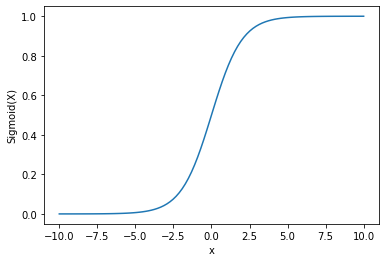

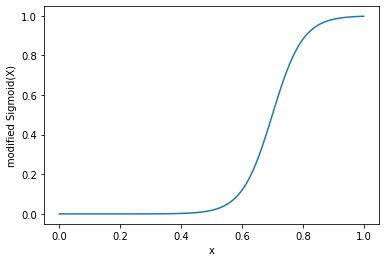

In [345]:
def sigmoid(x, a=1):
    return 1/(1 + np.exp(-a*x))

x = np.linspace(-10, 10, 100) 
z = sigmoid(x) 
  
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 
  
plt.show() 

x = np.linspace(0, 1, 100) 
z = sigmoid(20*x-14) 
  
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("modified Sigmoid(X)") 
  
plt.show() 

In [346]:
def dmtph_match_score(x):
    '''
    This function gives rewards for "ascii_norm_match" & "strong_match", but penalties for the rest
    i.e. non-linear weighting
    '''
    return sigmoid(20*(x-0.7))

x = np.linspace(0, 1, 5)
print(x)
print(dmtph_match_score(x))

[0.   0.25 0.5  0.75 1.  ]
[8.31528028e-07 1.23394576e-04 1.79862100e-02 7.31058579e-01
 9.97527377e-01]


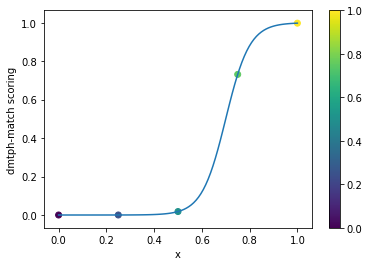

In [347]:
x = np.linspace(0, 1, 100) 
x2 = np.linspace(0, 1, 5)
 
plt.plot(x, dmtph_match_score(x)) 
plt.scatter(x2, dmtph_match_score(x2), c=x2, cmap='viridis')
plt.xlabel("x") 
plt.ylabel("dmtph-match scoring") 
plt.colorbar()  
plt.show() 

In [399]:
def get_dmtph_match(A_iter, B_iter, prefix2remove=prefixes_all):
    '''
    param:
        A_iter, B_iter: iterable with same length
    return:
        list of match scores
    '''
    assert len(A_iter) == len(B_iter)
    
    match_types = ['ASCII_norm_match', 'strong_match', 'weak_match', 'minimal_match', 'no_match']
    match_types.reverse()
    x = np.linspace(0, 1, 5)

    res = list()
    for tp in zip(A_iter, B_iter):
        match, match_type, dummy = match_doublemetaphone(tp, prefix2remove=prefix2remove)
        match_score = dmtph_match_score(x[match_types.index(match_type)])
        res.append(match_score)
    
    return res

In [356]:
dmtph_match = get_dmtph_match(df_test.in_text, df_test.matched)

In [357]:
df_test["dmtph_match"] = dmtph_match

In [358]:
df_test.head()

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match
0,J. Megan Greene,J. MEGAN GREENE,1.0,True,0.5,0.997527
1,Sinologist,sinologist,1.0,True,0.0,0.997527
2,Benjamin Netanyahu,Prime Minister Benjamin Netanyahu,1.0,False,0.0,0.731059
3,crystal,Crystal,1.0,True,0.0,0.997527
4,tate,Tate,1.0,True,0.0,0.997527


In [575]:
def get_string_distance(A_iter, B_iter, normalize=True, prefix2remove=prefixes_all):
    '''
    param:
        A_iter, B_iter: iterable with same length
    return:
        lists of invese-Levenshtein distance & Jaro-Winkler distance, respectively 
    '''
    assert len(A_iter) == len(B_iter)
    
    res_inv_lvst = list()
    res_jw = list()
    for w1, w2 in zip(A_iter, B_iter):
        if prefix2remove:  
            for prefix in prefix2remove:
                w1 = w1.replace(prefix, '')
                w2 = w2.replace(prefix, '')
        
            # remove any starting white space
            #w1 = w1[1:] if w1[0] == ' ' else w1
            #w2 = w2[1:] if w2[0] == ' ' else w2
        
        if normalize:
            w1, w2 = tuple(map(normalize_unicode_to_ascii, (w1, w2)))
        else:
            pass
        
        inv_lvst_dist = 1/lvst.distance(w1, w2) if lvst.distance(w1, w2) else 1 # avoid dividing by zero
        jw_dist = lvst.jaro_winkler(w1, w2)
        res_inv_lvst.append(inv_lvst_dist)
        res_jw.append(jw_dist)
    
    return res_inv_lvst, res_jw

In [362]:
inv_lvst_dist, jw_dist = get_string_distance(df_test.in_text, df_test.matched)

In [363]:
df_test["inv_lvst_dist"] = inv_lvst_dist
df_test["jw_dist"] = jw_dist

In [364]:
df_test.head()

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_dist
0,J. Megan Greene,J. MEGAN GREENE,1.0,True,0.5,0.997527,1.0,1.000000
1,Sinologist,sinologist,1.0,True,0.0,0.997527,1.0,1.000000
2,Benjamin Netanyahu,Prime Minister Benjamin Netanyahu,1.0,False,0.0,0.731059,1.0,0.899123
3,crystal,Crystal,1.0,True,0.0,0.997527,1.0,1.000000
4,tate,Tate,1.0,True,0.0,0.997527,1.0,1.000000


## Ensemble of Matchings

### Wrapper

In [610]:
def get_df_match(entity_names, entity_type, entity_subtypes=[]
                 , wiki_match=False
                 , prefix2remove=prefixes_all
                 , sorting_1st_letters=False
                 , partial_1st_letter_match=False
                 , co_doc_by_file=True       
                ):
    
    df = get_simliar_names_by_tfdif(entity_names)
    
    print("# of candidate pairs: {}".format(df.shape[0]))
    if wiki_match:
        df["wiki_match"] = get_wiki_match(df.in_text, df.matched)
    
    df["first_letter_match"] = get_1st_letters_match(df.in_text, df.matched
                                                     , sorting=sorting_1st_letters
                                                     , partial_match=partial_1st_letter_match
                                                     , prefix2remove=prefix2remove
                                                    )
    
    df["co_doc_ratio"] = get_co_document_ratio(df.in_text, df.matched
                                               , entity_type=entity_type
                                               , entity_subtypes=entity_subtypes
                                               , by_file=co_doc_by_file      
                                              )
    
    df["dmtph_match"] = get_dmtph_match(df.in_text, df.matched, prefix2remove=prefix2remove)
    
    inv_lvst_dist, jw_dist = get_string_distance(df.in_text, df.matched, prefix2remove=prefix2remove)
    df["inv_lvst_dist"] = inv_lvst_dist
    df["jw_sim"] = jw_dist # in python Levenshtein library, this is actually simlarity ranging [0, 1]
    
    return df

In [619]:
df_test = get_df_match(persons, 'Person', sorting_1st_letters=True, partial_1st_letter_match=True)

# of candidate pairs: 4216


In [620]:
df_test.head()

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim
0,Nathan Beauchamp Mustafaga,Nathan Beauchamp-Mustafaga,1.0,True,0.5,0.997527,1.0,1.0
1,Zeng Yu-Quang,Zeng Yu-quang,1.0,True,0.5,0.997527,1.0,1.0
2,dennis c. blair,Dennis C. Blair,1.0,True,0.0,0.997527,1.0,1.0
3,shao,Shao,1.0,True,0.0,0.997527,1.0,1.0
4,Drew,ew,1.0,True,0.0,0.997527,1.0,1.0


### Weighted average of matchings

In [621]:
def get_ensemble_match(df, weights=[]):
    '''
    get a weighted average of matching scores
    '''
    row_num = df.shape[0]
    matchings = df.columns[2:]
    if weights:
        assert len(weights) == len(matchings)
        weights = np.array(weights)
    else:
        weights = np.ones(len(matchings))
    
    match_score = pd.Series(np.zeros(row_num), dtype='float64')
    for weight, matching in zip(weights, matchings):
        match_score += weight*df[matching]
    
    match_score = match_score/weights.sum()
    
    return match_score

In [727]:
def add_match_score(df, weights=[]):
    if 'match_score' in df.columns:
        df.drop(['match_score'], axis=1, inplace=True)
    df['match_score'] = get_ensemble_match(df, weights=weights)
    df.sort_values(by='match_score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [623]:
weights_person = [4,2,0.5,1,1,1]
add_match_score(df_test, weights=weights_person)

In [693]:
df_test.head(10)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
0,Nathan Beauchamp Mustafaga,Nathan Beauchamp-Mustafaga,1.0,True,0.5,0.997527,1.0,1.0,0.973424
1,Zeng Yu-Quang,Zeng Yu-quang,1.0,True,0.5,0.997527,1.0,1.0,0.973424
6,Marketization,marketization,1.0,True,0.5,0.997527,1.0,1.0,0.973424
230,Dr Jagannath P. Panda,Dr. Jagannath P. Panda,1.0,True,0.5,0.997527,1.0,1.0,0.973424
220,KU GUISHENG,Ku Guisheng,1.0,True,0.5,0.997527,1.0,1.0,0.973424
279,Greg Chung,Greg'' Chung,1.0,True,0.5,0.997527,1.0,1.0,0.973424
250,Minister Narendra Modi,minister Narendra Modi,1.0,True,0.5,0.997527,1.0,1.0,0.973424
247,JIN W. MOK,Jin W. Mok,1.0,True,0.5,0.997527,1.0,1.0,0.973424
246,De Brauw,de Brauw,1.0,True,0.5,0.997527,1.0,1.0,0.973424
146,Secretary Zhang Shengmin,General Zhang Shengmin,1.0,True,0.5,0.997527,1.0,1.0,0.973424


In [625]:
df_test.tail(50)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
3194,Chang Zheng,Zheng Zhen,0.742168,False,0.000000,8.315280e-07,0.333333,0.842424,0.436256
2917,Vice President Bush,Vice President George Bush,0.755366,False,0.333333,8.315280e-07,0.142857,0.811343,0.436035
4187,Sun Zhuangzhi,Xu Zhuangzhi,0.700957,False,0.000000,8.315280e-07,0.500000,0.830031,0.435143
3965,Shehui Fazhan Dishierge Wunian Guihua Gangyao,Shehui Fazhan Dishierge,0.709414,False,0.500000,8.315280e-07,0.045455,1.000000,0.435064
3294,Li Chunyuan,Kang Chunyuan,0.737128,False,0.500000,8.315280e-07,0.250000,0.670163,0.433545
1995,fense Secretary William Cohen,William Cohen,0.802594,False,0.000000,8.315280e-07,0.166667,0.740891,0.433467
3843,Liu Ping,Yu Ping,0.714315,False,0.000000,8.315280e-07,0.500000,0.757937,0.433179
4017,fromtheblue,boltfromtheblue,0.707366,False,0.500000,8.315280e-07,0.250000,0.774747,0.432023
3970,Haiyan Wang,Haiyang Zhang,0.709169,False,0.000000,8.315280e-07,0.333333,0.930443,0.431627
3503,Richard H. Kohn,Richard H,0.728063,False,0.000000,8.315280e-07,0.200000,0.988095,0.431615


In [626]:
first_letters("Gen Yuri Baluyevskiy", sorting=True)

'by'

In [627]:
first_letters("Yuri Baluyevskiy", sorting=True)

'by'

In [628]:
'Gen' in prefixes_all

True

In [629]:
get_1st_letters_match(["Gen Yuri Baluyevskiy"], ["Yuri Baluyevskiy"]
                                                     , sorting=True
                                                     , partial_match=True
                                                     , prefix2remove=prefixes_all
                                                    )

[True]

### Cut-off

In [630]:
df_test.match_score.describe()

count    4216.000000
mean        0.707770
std         0.130963
min         0.344740
25%         0.619767
50%         0.678420
75%         0.806870
max         0.973424
Name: match_score, dtype: float64

In [631]:
df_test.match_score.quantile(.25)

0.6197666623636352

In [632]:
def cut_off(df, q=None, lower_bound=0.0):
    assert lower_bound >= 0.0 and lower_bound <= 1.0
    if not lower_bound:
        if not q:
            return df[df.match_score > df.match_score.mean()]
        else:
            assert type(q) == float
            return df[df.match_score > df.match_score.quantile(q)]
    else: # given nonzero lowever bound, use it as a filter
        eps = 1e-10
        return df[df.match_score >= lower_bound-eps] # inclusive

In [633]:
df_match = cut_off(df_test)

In [634]:
df_test.shape

(4216, 9)

In [635]:
df_match.shape

(1767, 9)

In [636]:
df_match.tail()

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
1555,Ayatollah,Ayatollah Kho,0.830022,True,0.333333,8.315280e-07,0.250000,0.989744,0.708053
1279,Yang. Zhang,Zhang Yang,0.850810,True,0.500000,8.315280e-07,0.250000,0.822222,0.707944
1869,ng Zhiqian,Zhiqian,0.810371,True,0.500000,8.315280e-07,0.333333,0.900000,0.707876
1321,G. Wagner,Wagner,0.847756,True,0.000000,8.315280e-07,0.500000,0.833333,0.707827
1934,Sir Francis Drakethat,Sir Francis Drake,0.806074,True,0.500000,8.315280e-07,0.250000,1.000000,0.707821


## Normalizing algorithms

### Connected-Components

In [637]:
edge_list = list(df_match[["in_text", "matched", "match_score"]].itertuples(index=False, name=None))

In [638]:
edge_list[:5]

[('Nathan Beauchamp Mustafaga',
  'Nathan Beauchamp-Mustafaga',
  0.9734239344045651),
 ('Marketization', 'marketization', 0.973423934404565),
 ('Zeng Yu-Quang', 'Zeng Yu-quang', 0.973423934404565),
 ('Dr Jagannath P. Panda', 'Dr. Jagannath P. Panda', 0.9734239344045648),
 ('Greenfield', 'greenfield', 0.9734239344045648)]

In [639]:
# generate graph
graph_ = nx.Graph()
graph_.add_weighted_edges_from(edge_list)

# extract connected components and reverse sort by length of components
connected_comp = [c for c in nx.connected_components(graph_)]
connected_comp.sort(key=len, reverse=True)

In [640]:
def get_connected_comp(df):
    edge_list = list(df[["in_text", "matched", "match_score"]].itertuples(index=False, name=None))
    graph_ = nx.Graph()
    graph_.add_weighted_edges_from(edge_list)

    # extract connected components and reverse sort by length of components
    connected_comp = [c for c in nx.connected_components(graph_)]
    connected_comp.sort(key=len, reverse=True)
    
    return connected_comp

In [641]:
# Definitely simple averaging over matchings are not optimal
connected_comp

[{'Philip',
  'Philip C',
  'Philip C.',
  'Philip E.',
  'Philipp',
  'Phillip',
  'Phillip C',
  'Phillip II'},
 {'Chistopher J.',
  'Christoph',
  'Christopher',
  'Christopher A.',
  'Christopher Howe',
  'Christopher J.',
  'Christopher K',
  'Christopher W'},
 {'General Secretary Zhao Ziyang',
  'Party Secretary Zhao Ziyang',
  'Premier Zhao Ziyang',
  'Secretary Zhao Ziyang',
  'Zhao Ziyang',
  'Zhao Ziyangs'},
 {'Defence Minister Ehud Barak',
  'Defense Minister Ehud Barak',
  'Ehud Barak',
  'Ehud Baraks',
  'Minister Ehud Barak',
  'Prime Minister Ehud Barak'},
 {'Richard',
  'Richard E.',
  'Richard M',
  'Richard M.',
  'Richard P',
  'Richard T'},
 {'J. Michael',
  'Michael',
  'Michael A.',
  'Michael D',
  'Michael.',
  'W. Michael'},
 {'Dr Manmohan Singh',
  'Dr. Manmohan Singh',
  'Manmohan Singh',
  'Prime Minister Manmohan Singh',
  'Prime Minister Manmohan Singhs'},
 {'Minister Narendra Modi',
  'Narendra Modi',
  'Prime Minister Narendra Modi',
  'Prime Minister Na

### DKE-Intervention/Post-processing
- Given the refined analysis so far, it's now feasible to monitor groups of simliar terms. Domain-Knowledge Expert intervention may improve the final result.
- **Work-Flow**: 
    - Get postprocessing data by using *get_postProcessingUnits()*
    - &rarr; Manual insepction to get *index2exclude*, *index2connect* & *comp2add* 
    - &rarr; Chunking & Updating *index2exclude* with *chunking()* 
    - &rarr; Add *comp2add* & complete *connected_comp_final*; 

In [642]:
def get_postProcessigUnits(connected_comp):
    connected_comp_short_ = sorted([list(comp) for comp in connected_comp if len(comp) == 2], key=lambda x:x[0])
    connected_comp_long_ = sorted([list(comp) for comp in connected_comp if len(comp) > 2], key=lambda x:x[0])
    connected_comp_all_ = sorted([list(comp) for comp in connected_comp], key=lambda x:x[0])
    
    connected_comp_short = [(i, comp) for i, comp in enumerate(connected_comp_short_)]
    connected_comp_long = [(i, comp) for i, comp in enumerate(connected_comp_long_)]
    connected_comp_all = [(i, comp) for i, comp in enumerate(connected_comp_all_)]
    
    return connected_comp_short, connected_comp_long, connected_comp_all 

In [643]:
connected_comp_short, connected_comp_long, connected_comp_all = get_postProcessigUnits(connected_comp)

In [644]:
print(len(connected_comp_short))
print(len(connected_comp_long))
print(len(connected_comp_all))

1088
282
1370


In [645]:
connected_comp_short[:20] # looks good

[(0, ['A. Berkofski', 'A. Berkofsky']),
 (1, ['A. Finkelstein', 'Finkelstein']),
 (2, ['A. K. Antony', 'A.K. Antony']),
 (3, ['A. Nelson', 'Nelson']),
 (4, ['A. Newman', 'Newman']),
 (5, ['A. Scobell', 'Scobell']),
 (6, ['Aaron Friedberg', 'Aaron L. Friedberg']),
 (7, ['Aaron L', 'Aaron L.']),
 (8, ['Acemoglu', 'D. Acemoglu']),
 (9, ['Adm. Jonathan W. Greenert', 'Jonathan W. Greenert']),
 (10, ['Admiral -Lyle Goldstein', 'Lyle Goldstein']),
 (11, ['Admiral Greenert', 'Greenert']),
 (12, ['Admiral Harris', 'Harris']),
 (13, ['Admiral Howard', 'Howard']),
 (14, ['Admiral Rogers', 'Rogers']),
 (15, ['Admiral Sir Henry', 'Henry']),
 (16, ['Admiral Yin Zhuo', 'Yin Zhuo']),
 (17, ['Admiral Yuan Yubai', 'Yuan Yubai']),
 (18, ['Ahmadinejad', 'President Ahmadinejad']),
 (19, ['Akinwande', 'A. I. Akinwande'])]

In [646]:
len(connected_comp_long)

282

In [647]:
connected_comp_long # not good for some groups

[(0, ['A. Schwartz', 'Schwartz', 'General Schwartz']),
 (1, ['Adama', 'Adam Wu', 'Adam']),
 (2, ['Admiral Jonathan', 'Jonathan.', 'Jonathan']),
 (3, ['Admiral Ma', 'Mr. Ma', 'Ma']),
 (4, ['Admiral Zhao', 'Premier Zhao', 'Zhao', 'Zhao.']),
 (5, ['Alexander W', 'Alexander II', 'Alexander', 'Alexander C']),
 (6, ['Ambassador Glaspie', 'Glaspie', 'Ambassador Glaspies']),
 (7, ['Anthony', 'Anthony P', 'Anthony S', 'Anthony H.']),
 (8, ['Arthur S', 'Arthur S.', 'Arthur']),
 (9, ['Baluyevsky', 'Baluyevskys', 'General Baluyevsky']),
 (10, ['Barack Obama', 'President Barack Obama', 'Barack Obamas']),
 (11, ['Ben.', 'ben', 'Ben E', 'Ben']),
 (12, ['Benjamin A.', 'Benjamin.', 'Prime Minister Benjamin']),
 (13, ['Bill', 'bill', 'President Bill']),
 (14, ['Bill Clintons', 'Bill Clinton', 'President Bill Clinton']),
 (15, ['Blasko.', 'J. Blasko', 'Blasko']),
 (16, ['Brooke', 'Brookes', 'Brook']),
 (17, ['C. B. Sung', 'C.B. Sung', 'C. B. Sungs']),
 (18, ['Carl.', 'Carl', 'Carl H.']),
 (19, ['Carney',

In [657]:
# manual insepction to excude, connect & add
index2exclude = [5,7,19,20,23,25,27,30,33,48,49,52,58,65,87,100,103,127,149,186,204,218,224,251]
index2connect = [(13,14,26), (166,10)]
comp2add = [['cooper', 'Cooper'],
            ['Ed', 'ed'],
            ['Gene', 'gene'],
            ['George W. Bush', 'President George W Bush', 'President George W. Bushs','President George W. Bush', 'President George Bush'],
            ['Philip C.', 'Phillip C', 'Philip C'],
            ['Phillip', 'Philip', 'Philipp']
           ]

In [665]:
len(index2exclude)

34

In [765]:
def chunking(connected_comp_any, index2connect=[] ,index2exclude=[]):
    chunks = list()
    if index2connect:
        for tp in index2connect: 
            chunk = list()
            for idx in tp:
                chunk.extend(list(connected_comp_any[idx][1]))
                index2exclude.append(idx)

            chunks.append(chunk)
        
    return chunks, index2exclude

In [766]:
def get_comp_final(connected_comp, connected_comp_short, is_all=True
                   , *, index2connect=[], index2exclude=[], comp2add=[]):
    chunks, index2exclude = chunking(connected_comp, index2connect=index2connect, index2exclude=index2exclude)
    
    res = [list(a[1]) for i, a in enumerate(connected_comp) if i not in index2exclude]
    res.extend(chunks)
    res.extend(comp2add)
    
    if not is_all:
        res += [list(a[1]) for a in connected_comp_short]
    
    return res

In [663]:
connected_comp_final = get_comp_final(connected_comp_long, connected_comp_short, is_all=False
                                     , index2connect=index2connect
                                     , index2exclude=index2exclude
                                     , comp2add=comp2add
                                     )

In [664]:
print(len(connected_comp))
print(len(connected_comp_final))

1370
1349


In [666]:
connected_comp_final[:100]

[['A. Schwartz', 'Schwartz', 'General Schwartz'],
 ['Adama', 'Adam Wu', 'Adam'],
 ['Admiral Jonathan', 'Jonathan.', 'Jonathan'],
 ['Admiral Ma', 'Mr. Ma', 'Ma'],
 ['Admiral Zhao', 'Premier Zhao', 'Zhao', 'Zhao.'],
 ['Ambassador Glaspie', 'Glaspie', 'Ambassador Glaspies'],
 ['Arthur S', 'Arthur S.', 'Arthur'],
 ['Baluyevsky', 'Baluyevskys', 'General Baluyevsky'],
 ['Ben.', 'ben', 'Ben E', 'Ben'],
 ['Benjamin A.', 'Benjamin.', 'Prime Minister Benjamin'],
 ['Blasko.', 'J. Blasko', 'Blasko'],
 ['Brooke', 'Brookes', 'Brook'],
 ['C. B. Sung', 'C.B. Sung', 'C. B. Sungs'],
 ['Carl.', 'Carl', 'Carl H.'],
 ['Chatterton.', 'Chattertons', 'Chatterton'],
 ['Chen Bingde', 'General Chen Bingde', 'Gen. Chen Bingde'],
 ['Clares', 'Mr. Clare', 'Clare'],
 ['D. Swaine', 'Swaine', 'Swain'],
 ['Dan', 'General Dan', 'dan'],
 ['David C. Logans', 'David C. Logan', 'David Logan', 'David C. Logan.'],
 ['David M. Finkelstein.',
  'David M. Finkelstein',
  'Dr. David M. Finkelstein',
  'David M. Finklestein'],
 ['

### Normalization
We choose the normalized term for each connected component
- Levenshtein-Median modifies original term (not desirable)
- length-based method sometimes yeilds multiple choices

After discussion with the dev team, we apply the followng rules to choose normalized terms

1. no period at the end
2. no hyphen anywhere
3. should start with a Uppercased letter
4. choose by string length (longest or shorted with repect to entity types)

I choose simply the first (or the last) term of each connected component as its normalized term.

In [667]:
def choose_normalized(connected_comp, choice='lvst'):
    '''
    choose one normalized term for each connected component by rule-based system
    NOTE: "longest = False" will choose the shortest
    '''
    res = list()
    for comp in connected_comp:
          
        # Rule-1: no period at the end
        temp = [name for name in comp if name[-1] != '.']
        comp = temp if temp else comp
        
        # Rule-2.1: no hyphen anywhere
        temp = [name for name in comp if '-' not in name]
        comp = temp if temp else comp
        
        # Rule-2.2: no '/' anywhere
        temp = [name for name in comp if '/' not in name]
        comp = temp if temp else comp
        
        # Rule-3: start with uppercase
        temp = [name for name in comp if name[0].isupper()]
        comp = temp if temp else comp
        
        # Rule-4: no unicode (no '\u2003')
        temp = []
        for name in comp:
            normal = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore')
            val = normal.decode("utf-8")
            temp.append(val)
            
        comp = list(set(temp)) if temp else comp     
        
        # Rule-5: choose by length or Levenshtein Median
        comp.sort(key=len)
        if choice == 'long':
            res.append(comp[-1])
        elif choice == 'short':
            res.append(comp[0])
        elif choice == 'lvst':
            res.append(lvst.median(comp))
        else:
            print("Not a valid choice methond")
            return None
    
    return res

In [674]:
normalized_terms = choose_normalized(connected_comp_final, choice='long')

In [675]:
len(normalized_terms)

1349

In [676]:
normalized_terms[:50]

['General Schwartz',
 'Adam Wu',
 'Admiral Jonathan',
 'Admiral Ma',
 'Premier Zhao',
 'Ambassador Glaspies',
 'Arthur S',
 'General Baluyevsky',
 'Ben E',
 'Prime Minister Benjamin',
 'J. Blasko',
 'Brookes',
 'C. B. Sungs',
 'Carl',
 'Chattertons',
 'General Chen Bingde',
 'Mr. Clare',
 'D. Swaine',
 'General Dan',
 'David C. Logans',
 'Dr. David M. Finkelstein',
 'Jose Dedeurwaerder',
 'Defence Minister Moshe Arens',
 'Demonopolization',
 'Deng',
 'Dennis J. Blasko',
 'Deputy Secretary Carter',
 'Major General Feng Jianhua',
 'Disarticulation',
 'Dmitrii Trenin',
 'President Donald Trump',
 'Douglas B',
 'Dr. Erickson',
 'Dr. S. Jaishankar',
 'Dr. Tai Ming Cheung',
 'Prime Minister Ehud Olmert',
 'Evan S. Medeiros',
 'President Franklin D. Roosevelt',
 'Gabriel B',
 'President Dwight D. Eisenhower',
 'Gen. K. Sundarji',
 'Minister Zhang Aiping',
 'General Chi',
 'General Joseph',
 'Defence Minister Liang Guanglie',
 'Gen. Norton A. Schwartz',
 'General Xu Qiliang',
 'General Yi Xiao

In [677]:
def make_norm_dict(components, norms):
    raw2normalized = dict()
    normalized2raw = defaultdict(list)
    for comp, norm in zip(components, norms):
        for name in comp:
            raw2normalized[name] = norm
            normalized2raw[norm].append(name)
    
    return raw2normalized, normalized2raw

In [678]:
raw2normalized, normalized2raw = make_norm_dict(connected_comp_final, normalized_terms)

In [679]:
print("# of raw (in-snippet) entiteis normalized: {}".format(len(raw2normalized)))
print("# of normalized keys: {}".format(len(normalized2raw)))

# of raw (in-snippet) entiteis normalized: 3032
# of normalized keys: 1348


# Entity Normalization

In [931]:
data_path = './data/'

## Person names

In [686]:
df_persons = get_df_match(persons, 'Person', wiki_match=False, sorting_1st_letters=True)

# of candidate pairs: 4216


In [690]:
weights_person = [4,2,0.5,1,1,1]
add_match_score(df_persons, weights=weights_person)

In [691]:
df_persons = cut_off(df_persons)

In [692]:
df_persons.shape

(1643, 9)

In [694]:
df_persons.head(10)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
0,Nathan Beauchamp Mustafaga,Nathan Beauchamp-Mustafaga,1.0,True,0.5,0.997527,1.0,1.0,0.973424
6,Marketization,marketization,1.0,True,0.5,0.997527,1.0,1.0,0.973424
1,Zeng Yu-Quang,Zeng Yu-quang,1.0,True,0.5,0.997527,1.0,1.0,0.973424
246,De Brauw,de Brauw,1.0,True,0.5,0.997527,1.0,1.0,0.973424
151,CHARLES G. SODINI,Charles G. Sodini,1.0,True,0.5,0.997527,1.0,1.0,0.973424
35,Zhang Qingmin,ZHANG QINGMIN,1.0,True,0.5,0.997527,1.0,1.0,0.973424
77,Dr. Manmohan Singh,Dr Manmohan Singh,1.0,True,0.5,0.997527,1.0,1.0,0.973424
38,robert f. willard,Robert F. Willard,1.0,True,0.5,0.997527,1.0,1.0,0.973424
146,Secretary Zhang Shengmin,General Zhang Shengmin,1.0,True,0.5,0.997527,1.0,1.0,0.973424
236,Antiaccess,antiaccess,1.0,True,0.5,0.997527,1.0,1.0,0.973424


In [695]:
df_persons.tail(10)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
1574,John A. Donaldson,John Donaldson,0.829001,False,0.333333,7.310586e-01,0.500000,0.955357,0.596746
1164,Richard Bitzinger,Richard A Bitzinger,0.860299,False,0.000000,7.310586e-01,0.500000,0.992982,0.596341
1184,Tien Kung,Tien Kung-I,0.858542,False,0.000000,7.310586e-01,0.500000,0.993939,0.595702
1200,Zhang Hongqing,hang Hongqing,0.857010,False,0.500000,8.315280e-07,1.000000,0.976190,0.595182
2117,James Michener,James A. Michener,0.796512,False,0.500000,7.310586e-01,0.500000,0.983333,0.594783
1111,Ralph,Ralph A,0.865806,False,0.000000,7.310586e-01,0.500000,0.952381,0.594386
2184,Richard Carney,Richard W. Carney,0.792999,False,0.500000,7.310586e-01,0.500000,0.991667,0.594181
1273,Evan Feigenbaum,Evan A. Feigenbaum,0.851460,False,0.125000,7.310586e-01,0.500000,0.941468,0.593776
3288,Ben Kaspit,Ben Caspit,0.737360,False,0.000000,7.310586e-01,1.000000,0.960000,0.593737
1516,Zhen Zhou Wu,Zhen Zhou,0.833043,False,0.500000,7.310586e-01,0.333333,0.991667,0.593498


In [698]:
f_name = 'person_matching' + ver_string
df_persons.to_csv(data_path + f_name + ".csv")

In [699]:
persons_connected = connected_comp_final

In [700]:
len(persons_connected)

1349

In [701]:
persons_raw2norm = raw2normalized
persons_norm2raw = normalized2raw

In [702]:
list(persons_raw2norm.items())[:5]

[('A. Schwartz', 'General Schwartz'),
 ('Schwartz', 'General Schwartz'),
 ('General Schwartz', 'General Schwartz'),
 ('Adama', 'Adam Wu'),
 ('Adam Wu', 'Adam Wu')]

In [703]:
list(persons_norm2raw.items())[:5]

[('General Schwartz', ['A. Schwartz', 'Schwartz', 'General Schwartz']),
 ('Adam Wu', ['Adama', 'Adam Wu', 'Adam']),
 ('Admiral Jonathan', ['Admiral Jonathan', 'Jonathan.', 'Jonathan']),
 ('Admiral Ma', ['Admiral Ma', 'Mr. Ma', 'Ma']),
 ('Premier Zhao', ['Admiral Zhao', 'Premier Zhao', 'Zhao', 'Zhao.'])]

In [704]:
list(persons_norm2raw.keys())

['General Schwartz',
 'Adam Wu',
 'Admiral Jonathan',
 'Admiral Ma',
 'Premier Zhao',
 'Ambassador Glaspies',
 'Arthur S',
 'General Baluyevsky',
 'Ben E',
 'Prime Minister Benjamin',
 'J. Blasko',
 'Brookes',
 'C. B. Sungs',
 'Carl',
 'Chattertons',
 'General Chen Bingde',
 'Mr. Clare',
 'D. Swaine',
 'General Dan',
 'David C. Logans',
 'Dr. David M. Finkelstein',
 'Jose Dedeurwaerder',
 'Defence Minister Moshe Arens',
 'Demonopolization',
 'Deng',
 'Dennis J. Blasko',
 'Deputy Secretary Carter',
 'Major General Feng Jianhua',
 'Disarticulation',
 'Dmitrii Trenin',
 'President Donald Trump',
 'Douglas B',
 'Dr. Erickson',
 'Dr. S. Jaishankar',
 'Dr. Tai Ming Cheung',
 'Prime Minister Ehud Olmert',
 'Evan S. Medeiros',
 'President Franklin D. Roosevelt',
 'Gabriel B',
 'President Dwight D. Eisenhower',
 'Gen. K. Sundarji',
 'Minister Zhang Aiping',
 'General Chi',
 'General Joseph',
 'Defence Minister Liang Guanglie',
 'Gen. Norton A. Schwartz',
 'General Xu Qiliang',
 'General Yi Xiao

In [706]:
f_name = 'persons_raw2norm' + ver_string
json_dp = json.dumps(persons_raw2norm)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

f_name = 'persons_norm2raw' + ver_string
json_dp = json.dumps(persons_norm2raw)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

In [186]:
#with open("persons_norm.json") as json_file: 
#    test_dict = json.load(json_file) 

In [187]:
#test_dict

## Company names

In [707]:
len(companies)

6799

In [708]:
companies[:20]

['VTRs',
 'United States Technology Transfer',
 'Taiwans semiconductor',
 'China Central Depository',
 'Taiwan Statistical',
 'Eurasian Businesses',
 'Defense Industrial Security',
 'AI',
 'Zhongguancun Energy',
 'CNN Wire',
 'Silicon Labs',
 'AVIC Aviation Industry Corporation of China',
 'iants. Architectural',
 'UNITED',
 'Berghahn Books',
 'ommunications Equipment',
 'CNA',
 'CMC direction.36',
 'RussianChinese Relations',
 'nufacturing Units']

In [738]:
%%time
df_companies = get_df_match(companies
                             , entity_type='Company'
                             , sorting_1st_letters=True
                             , partial_1st_letter_match=True)

# of candidate pairs: 1697
CPU times: user 700 ms, sys: 4.15 ms, total: 704 ms
Wall time: 618 ms


In [739]:
df_companies.head()

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim
0,Premodern China,premodern China,1.0,True,0.5,0.997527,1.0,1.0
1,China Technology,China Defense Technology,1.0,True,0.0,0.997527,1.0,1.0
2,Naval aviation,Naval Aviation,1.0,True,0.5,0.997527,1.0,1.0
3,Bell Labs,Bell labs,1.0,True,0.5,0.997527,1.0,1.0
4,Defence industries,defence industries,1.0,True,0.4,0.997527,1.0,1.0


In [740]:
df_companies[df_companies.matched == "Joint Ventures"]

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim
81,Joint ventures,Joint Ventures,1.0,True,0.0,0.997527,1.0,1.0
90,joint ventures,Joint Ventures,1.0,True,0.0,0.997527,1.0,1.0


In [741]:
weights_companies = [2, 4, 1, 0.5, 0.5, 0.5] # can discuss why

In [742]:
add_match_score(df_companies, weights=weights_companies)

In [743]:
df_companies.match_score.describe()

count    1697.000000
mean        0.618372
std         0.236022
min         0.199499
25%         0.314062
50%         0.723002
75%         0.780431
max         0.941031
Name: match_score, dtype: float64

In [744]:
df_companies.head(40)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
0,Premodern China,premodern China,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031
1,Naval aviation,Naval Aviation,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031
2,Antiaccess,antiaccess,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031
3,AntiAccess,antiaccess,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031
4,Chinas shipbuilding industry,Chinas Shipbuilding Industry,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031
5,Micro Enterprises,micro enterprises,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031
6,JEEP,Jeep,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031
7,Militarypolitical,MilitaryPolitical,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031
8,Panini,PANINI,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031
9,Antiaccess,AntiAccess,1.000000,True,0.500000,0.997527,1.0,1.0,0.941031


In [745]:
df_companies.tail(40)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
1657,China Electronic Systems,BAE Systems Electronic Systems,0.740490,False,0.0,8.315280e-07,0.111111,0.679422,0.220735
1658,Bell Laboratories,National Laboratories,0.722626,False,0.0,8.315280e-07,0.142857,0.711018,0.220258
1659,Service Corporation,Enterprise Service Corporation,0.770918,False,0.0,8.315280e-07,0.090909,0.564822,0.219965
1660,Taiwans manufacturing,Manufacturing Manufacturing,0.731901,False,0.0,8.315280e-07,0.100000,0.711594,0.219953
1661,Beijing Municipality,Shanghai Municipality,0.710028,False,0.0,8.315280e-07,0.125000,0.770635,0.219750
1662,US Semiconductor,Semiconductor Industry,0.745077,False,0.0,8.315280e-07,0.083333,0.670455,0.219653
1663,China Law Publishing House,PLA Publishing House,0.706693,False,0.0,8.315280e-07,0.142857,0.762011,0.219508
1664,Commission Technology Technology,mation Technology,0.748620,False,0.0,8.315280e-07,0.071429,0.661578,0.219264
1665,Internet+ Manufacturing,Manufacturing Manufacturing,0.733555,False,0.0,8.315280e-07,0.100000,0.689113,0.219020
1666,National Semiconductor,Semiconductor corporation,0.744679,False,0.0,8.315280e-07,0.055556,0.688653,0.218996


In [747]:
df_companies.tail(400)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
1297,nce Systems Unveiled,Air Defence Systems Unveiled,0.786975,False,0.5,8.315280e-07,0.333333,0.733333,0.306739
1298,Orlando Helicopter,Orlando Helicopter Airways Inc,0.782083,False,0.5,8.315280e-07,0.083333,1.000000,0.306569
1299,Bell Telephone,Bell Telephone Laboratories,0.783586,False,0.5,8.315280e-07,0.076923,1.000000,0.306545
1300,Chinese National Automotive Industrial Corpora...,Automotive Industrial Corporation,0.855696,False,0.5,8.315280e-07,0.058824,0.725051,0.306274
1301,China Shipbuilding Trading Company Limitednaval,China Shipbuilding Trading Company,0.781002,False,0.5,8.315280e-07,0.076923,1.000000,0.305937
...,...,...,...,...,...,...,...,...,...
1692,Development Group,China Development,0.703815,False,0.0,8.315280e-07,0.083333,0.637255,0.207991
1693,economy. China,National Economy,0.722694,False,0.0,8.315280e-07,0.076923,0.538462,0.206245
1694,Indian Ocean Pacific Command,Pacific Command,0.722213,False,0.0,8.315280e-07,0.076923,0.510847,0.204507
1695,Bank of Chinas,Commercial Bank of Chinas,0.724112,False,0.0,8.315280e-07,0.090909,0.426667,0.200825


In [750]:
df_companies.tail(500)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
1197,National Guizhou Aviation Industry,National Guizhou Aviation Industry Group,0.925414,False,0.5,8.315280e-07,0.166667,1.000000,0.345196
1198,na Shipbuilding Trading Corporation,China Shipbuilding Trading Corporation,0.923383,False,0.5,8.315280e-07,0.333333,0.816541,0.343730
1199,SIPRI Arms Procurement Procurement,SIPRI Arms Procurement,0.934809,False,0.5,8.315280e-07,0.083333,1.000000,0.342504
1200,Chinas Advanced Weapons Systems Industry,Chinas Advanced Weapons Systems,0.923684,False,0.5,8.315280e-07,0.111111,1.000000,0.341520
1201,China Aerospace Time Instrument Corporation,Aerospace Time Instrument Corporation,0.958433,False,0.5,8.315280e-07,0.166667,0.791326,0.340690
...,...,...,...,...,...,...,...,...,...
1692,Development Group,China Development,0.703815,False,0.0,8.315280e-07,0.083333,0.637255,0.207991
1693,economy. China,National Economy,0.722694,False,0.0,8.315280e-07,0.076923,0.538462,0.206245
1694,Indian Ocean Pacific Command,Pacific Command,0.722213,False,0.0,8.315280e-07,0.076923,0.510847,0.204507
1695,Bank of Chinas,Commercial Bank of Chinas,0.724112,False,0.0,8.315280e-07,0.090909,0.426667,0.200825


In [748]:
df_companies.match_score.describe()

count    1697.000000
mean        0.618372
std         0.236022
min         0.199499
25%         0.314062
50%         0.723002
75%         0.780431
max         0.941031
Name: match_score, dtype: float64

In [751]:
df_companies = cut_off(df_companies, q=0.25)

In [752]:
df_companies.shape

(1272, 9)

In [753]:
df_companies.tail(20)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
1252,te enterprises,nate enterprises,0.763325,False,0.500000,8.315280e-07,0.500000,0.898810,0.320712
1253,ngdu Aviation Industry,Hongdu Aviation Industry,0.767290,False,0.500000,8.315280e-07,0.500000,0.881313,0.320616
1254,China Radio Interna,China Radio International Eng,0.835958,False,0.500000,8.315280e-07,0.100000,1.000000,0.320225
1255,Second Artillerys Integrated,Second Artillerys,0.836459,False,0.500000,8.315280e-07,0.090909,1.000000,0.319809
1256,NTTC National Technology Transfer Centers,National Technology Transfer Centers,0.848201,False,0.500000,8.315280e-07,0.200000,0.834248,0.319238
1257,Japanese Aerospace Companies,Japanese Aerospace,0.830387,False,0.500000,8.315280e-07,0.100000,1.000000,0.318915
1258,ang Shipyard,chang Shipyard,0.762073,False,0.500000,8.315280e-07,0.500000,0.869048,0.318667
1259,Primary Aircraft Inventory,mary Aircraft Inventory,0.817470,False,0.500000,8.315280e-07,0.333333,0.809365,0.318387
1260,ASEAN China,ASEAN,0.833922,False,0.500000,8.315280e-07,0.166667,0.909091,0.318320
1261,FTI Con,FTI,0.822705,False,0.500000,8.315280e-07,0.250000,0.866667,0.318088


In [754]:
f_name = 'companies_matching' + ver_string
df_companies.to_csv(data_path + f_name + ".csv")

In [755]:
comp_companies = get_connected_comp(df_companies)

In [758]:
comp_companies_short, comp_companies_long, comp_companies_all = get_postProcessigUnits(comp_companies)

In [759]:
print(len(comp_companies_short))
print(len(comp_companies_long))

492
268


In [761]:
comp_companies_all

[(0,
  ['AHP Field Research Group',
   'Field Research Group',
   'Research Group',
   'Economics Research Group']),
 (1, ['AMC', 'AMC China', 'AMC.']),
 (2, ['AMCs', 'AMCs China']),
 (3, ['AMDs', 'AMDs Chinese', 'AMDs China']),
 (4, ['ARISTA', 'Arista']),
 (5, ['ASEAN China', 'ASEAN', 'ASEANs']),
 (6, ['AVIC Heavy', 'AVIC Heavy Machinery']),
 (7,
  ['AVIC Helicopter Marketing',
   'CASC Helicopter Marketing',
   'Tengoen Helicopter Marketing',
   'Helicopter Marketing',
   'Norinco Helicopter Marketing']),
 (8,
  ['AVICs China Aviation Industry General Aircraft',
   'China Aviation',
   'China Aviation Industry',
   'China Avia',
   'China Anda Aviation']),
 (9, ['Accor', 'accor']),
 (10, ['Admiral Yuan Yubais', 'Yuan Yubai']),
 (11,
  ['Advanced Equipment Manufacturing',
   'Meng Equipment Manufacturing',
   'Equipment Manufacturing']),
 (12, ['Advanced Manufacturing and Automation', 'Advanced Manufacturing']),
 (13, ['Advanced Micro Devices', 'Advanced Micro Devices Inc']),
 (14,
  

In [773]:
index2exclude = [0,7,25,93,152,198,209,221,223,227,278,284,307,308,311,475,646,686]
index2connect = [(1,2), (80,81), (99,100), (366,367,368), (709,710)]
comp2add = [['Chrysler Corporation','Chryslers','Chrysler','Chrysler.','Chrysler Corp'],
            ['Chryslers China', 'Chrysler Beijing'],
            ['Defence industries','Defense Industry','defence industries','Defense industries','Defense Industries','Defence Industries','defense industries'],
            ['Google', 'google.com', 'Googles', 'google'],
            ['Hongdu Aviation', 'Hongdu Avia'],
            ['satellites China','satellitesto China']
           ]

In [774]:
comp_companies_final = get_comp_final(comp_companies_all, comp_companies_short, is_all=True
                                     , index2connect=index2connect
                                     , index2exclude=index2exclude
                                     , comp2add=comp2add
                                     )

In [775]:
normalized_companies = choose_normalized(comp_companies_final, choice='long')

In [776]:
companies_raw2norm, companies_norm2raw = make_norm_dict(comp_companies_final, normalized_companies)

In [777]:
list(companies_raw2norm.items())[:5]

[('AMDs', 'AMDs Chinese'),
 ('AMDs Chinese', 'AMDs Chinese'),
 ('AMDs China', 'AMDs Chinese'),
 ('ARISTA', 'Arista'),
 ('Arista', 'Arista')]

In [778]:
list(companies_norm2raw.items())[:5]

[('AMDs Chinese', ['AMDs', 'AMDs Chinese', 'AMDs China']),
 ('Arista', ['ARISTA', 'Arista']),
 ('ASEAN China', ['ASEAN China', 'ASEAN', 'ASEANs']),
 ('AVIC Heavy Machinery', ['AVIC Heavy', 'AVIC Heavy Machinery']),
 ('AVICs China Aviation Industry General Aircraft',
  ['AVICs China Aviation Industry General Aircraft',
   'China Aviation',
   'China Aviation Industry',
   'China Avia',
   'China Anda Aviation'])]

In [779]:
companies_norm2raw["Chrysler Corporation"]

['Chrysler Corporation', 'Chryslers', 'Chrysler', 'Chrysler.', 'Chrysler Corp']

In [782]:
f_name = 'company_matching' + ver_string
df_companies.to_csv(data_path + f_name + ".csv")

In [783]:
f_name = 'companies_raw2norm' + ver_string
json_dp = json.dumps(companies_raw2norm)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

f_name = 'companies_norm2raw' + ver_string
json_dp = json.dumps(companies_norm2raw)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

## Location names
- This is upper-level entity type. (e.g. "Country" is a subtype of entity_type, "Location")

In [785]:
entity_unique['Location']['Facility']

{'Sevastopol', 'Stockholm'}

In [786]:
entity_unique['Location']['USTerritory']

{'Guam'}

In [788]:
len(locations)

4104

In [815]:
%%time
df_locations = get_df_match(locations, entity_type='Location', partial_1st_letter_match=True)

# of candidate pairs: 749
CPU times: user 375 ms, sys: 4.3 ms, total: 379 ms
Wall time: 368 ms


In [817]:
weights_locations = [4, 2, 0.5, 0.5, 0.5, 0.5] # can discuss why

In [818]:
add_match_score(df_locations, weights=weights_locations)

In [819]:
df_locations.match_score.describe()

count    749.000000
mean       0.781783
std        0.120781
min        0.380326
25%        0.705680
50%        0.774323
75%        0.886361
max        0.968595
Name: match_score, dtype: float64

In [820]:
df_locations.head()

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
0,Gulf emirates,Gulf Emirates,1.0,True,0.5,0.997527,1.0,1.0,0.968595
1,quintuple,Quintuple,1.0,True,0.5,0.997527,1.0,1.0,0.968595
2,Keji Guanli Yanjiu,Keji Guanli yanjiu,1.0,True,0.5,0.997527,1.0,1.0,0.968595
3,southern Jiangsu,Southern Jiangsu,1.0,True,0.5,0.997527,1.0,1.0,0.968595
4,Zhongguo hangkong,Zhongguo Hangkong,1.0,True,0.5,0.997527,1.0,1.0,0.968595


In [821]:
df_locations.tail(50)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
699,Chinas Sovremennyys,Sovremenny,0.714646,True,0.000000,8.315280e-07,0.111111,0.319298,0.634224
700,China York,York,0.741250,True,0.000000,8.315280e-07,0.166667,0.000000,0.631042
701,mid-earth,Earth,0.720380,True,0.000000,8.315280e-07,0.250000,0.000000,0.625815
702,Japans Tokyo,Tokyo,0.721796,True,0.050000,8.315280e-07,0.142857,0.000000,0.622952
703,Northeastern Region,North-Eastern Region,0.806741,False,0.500000,7.310586e-01,1.000000,0.956579,0.602598
704,ofang Keji Gongye Jinyibu Canyu Xibu Dakaifa,Guofang Keji Gongye Jinyibu Canyu Xibu Dakaifa,0.937600,False,0.500000,8.315280e-07,0.500000,0.928689,0.589343
705,East Germany,West Germany,0.804156,False,0.333333,7.310586e-01,0.500000,0.944444,0.558880
706,Eastern Pacific,Western Pacific,0.823856,False,0.166667,7.310586e-01,0.500000,0.860317,0.553056
707,West Indies,East Indies,0.764140,False,0.500000,7.310586e-01,0.500000,0.939394,0.548973
708,Western Europe,eastern Europe,0.810083,False,0.000000,7.310586e-01,0.500000,0.952381,0.541506


In [822]:
df_locations.tail(100)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
649,Tokyos Shanghai,Tokyos,0.731945,True,0.000000,8.315280e-07,0.111111,0.920000,0.680417
650,United,United War,0.710635,True,0.000000,8.315280e-07,0.250000,0.946667,0.680109
651,Qian Haiyan,Haiyan,0.770909,True,0.000000,8.315280e-07,0.200000,0.510101,0.679836
652,Colombo Mediterranean,Mediterranean,0.762060,True,0.125000,8.315280e-07,0.125000,0.526862,0.679584
653,Hong Kongfour,Hong Kong,0.700875,True,0.026316,8.315280e-07,0.250000,0.989744,0.679566
...,...,...,...,...,...,...,...,...,...
744,Changing Population,POPULATION,0.767896,False,0.000000,8.315280e-07,0.111111,0.453509,0.419237
745,Spain Denmark,DENMARK,0.745906,False,0.000000,8.315280e-07,0.166667,0.313187,0.402944
746,Lithuania Slovenia,SLOVENIA,0.734015,False,0.000000,8.315280e-07,0.100000,0.449074,0.401325
747,Chinas Russia,RUSSIA,0.701423,False,0.000000,8.315280e-07,0.142857,0.410256,0.385281


In [823]:
df_locations.tail(200)

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
549,Chinas Changjiang,Changjiang,0.805198,True,0.000000,8.315280e-07,0.142857,0.772157,0.709787
550,"Vietnam,100",Vietnam,0.767465,True,0.000000,8.315280e-07,0.250000,0.963636,0.709585
551,Lanzhou MR,Lanzhou,0.734963,True,0.166667,8.315280e-07,0.333333,0.970000,0.709356
552,Mianyang City,Mianyang,0.750504,True,0.166667,8.315280e-07,0.200000,0.974359,0.709066
553,Guofang,Guofang keji,0.730274,True,0.333333,8.315280e-07,0.200000,0.958333,0.708366
...,...,...,...,...,...,...,...,...,...
744,Changing Population,POPULATION,0.767896,False,0.000000,8.315280e-07,0.111111,0.453509,0.419237
745,Spain Denmark,DENMARK,0.745906,False,0.000000,8.315280e-07,0.166667,0.313187,0.402944
746,Lithuania Slovenia,SLOVENIA,0.734015,False,0.000000,8.315280e-07,0.100000,0.449074,0.401325
747,Chinas Russia,RUSSIA,0.701423,False,0.000000,8.315280e-07,0.142857,0.410256,0.385281


In [824]:
df_locations.match_score.describe()

count    749.000000
mean       0.781783
std        0.120781
min        0.380326
25%        0.705680
50%        0.774323
75%        0.886361
max        0.968595
Name: match_score, dtype: float64

In [811]:
df_locations.shape

(749, 9)

In [825]:
df_locations = cut_off(df_locations, q=0.5)

In [826]:
df_locations.shape

(374, 9)

In [827]:
df_locations.tail()

,in_text,matched,similarity,first_letter_match,co_doc_ratio,dmtph_match,inv_lvst_dist,jw_sim,match_score
369,Paracel,Paracels,0.805109,True,0.000000,8.315280e-07,1.000000,0.987500,0.776773
370,Singapore.33,Singapore,0.792128,True,0.027778,7.310586e-01,0.333333,0.991667,0.776304
371,United Statesin,United States,0.860457,True,0.012346,8.315280e-07,0.500000,1.000000,0.774750
372,2013-2015,20132015,0.710464,True,0.000000,7.310586e-01,1.000000,0.977778,0.774534
373,Djibouti,Djibouti.In,0.870401,True,0.111111,8.315280e-07,0.333333,0.981818,0.774342


In [828]:
f_name = 'locations_matching' + ver_string
df_locations.to_csv(data_path + f_name + ".csv")

In [829]:
comp_locations = get_connected_comp(df_locations)

In [830]:
comp_locations_short, comp_locations_long, comp_locations_all = get_postProcessigUnits(comp_locations)

In [831]:
len(comp_locations_short)

223

In [832]:
len(comp_locations_long)

61

In [833]:
comp_locations_all

[(0, ['19921993.70', '19921993']),
 (1, ['20002003', '20002007']),
 (2, ['20032005', '20032004', '20032008']),
 (3, ['20052006', '20052007']),
 (4, ['20062007', '20062008']),
 (5, ['20102015', '20102011']),
 (6, ['2012-2015', '2012-2016']),
 (7, ['2013-2015', '20132015', '20132016', '20132014']),
 (8, ['20142015', '20142016']),
 (9, ['ALGERIA', 'Algeria', 'Algeria.']),
 (10, ['ARMENIA', 'Armenia']),
 (11, ['ASIA', 'Asia', 'asia', 'Asia.']),
 (12, ['Abkhazians', 'Abkhazia', 'Abkhazia.']),
 (13, ['Afghanistan', 'Afghanistan.']),
 (14, ['Africa.10', 'Africa.', 'Africa']),
 (15, ['Agentstvo Voyennykh Novostey', 'Agentstvo Voyennykh Novestey']),
 (16, ['Al', 'al']),
 (17, ['Alaska.', 'Alaska']),
 (18, ['Americas', 'America', 'America.']),
 (19, ['Anhui', 'anhui']),
 (20, ['Annapolis', 'ANNAPOLIS']),
 (21, ['Arab emirates', 'Arab Emirates']),
 (22, ['Argentina', 'Argentinas']),
 (23, ['Asia-Pacific', 'Asia-Pacific.']),
 (24, ['Asiaand', 'Asiaan']),
 (25, ['Australia', 'Australia.']),
 (26, [

In [835]:
index2exclude = [0,1,2,3,4,5,6,7,8]
index2connect = [(18,236,237,239,241,280), (39,41,42,263), (32,33, 169), (52,53,54), (63,64,248), (70,75), (116,211),
                 (150, 153), (190,191), (235,240), (243,244), (249,250)]
comp2add = []

In [836]:
comp_locations_final = get_comp_final(comp_locations_all, comp_locations_short, is_all=True
                                     , index2connect=index2connect
                                     , index2exclude=index2exclude
                                     , comp2add=comp2add
                                     )

In [838]:
normalized_locations = choose_normalized(comp_locations_final, choice='short')

In [839]:
normalized_locations

['ALGERIA',
 'ARMENIA',
 'ASIA',
 'Abkhazia',
 'Afghanistan',
 'Africa',
 'Agentstvo Voyennykh Novostey',
 'Al',
 'Alaska',
 'Anhui',
 'Annapolis',
 'Arab emirates',
 'Argentina',
 'Asia-Pacific',
 'Asiaan',
 'Australia',
 'Austria',
 'BELARUS',
 'BELGIUM',
 'BOSNIA',
 'Baltic',
 'Bangladesh',
 'Berlin',
 'Bhutan',
 'Brazil',
 'Budui',
 'Bulgaria',
 'Cairo',
 'Cambodia',
 'Canada',
 'Central Asia',
 'Cfius',
 'Changchun',
 'Changzhou',
 'Chechnya',
 'Chen Xulin',
 'Cherokee',
 'Chinaan',
 'China Township',
 'Chinas West',
 'Co',
 'Conn',
 'Constantinople',
 'Coun',
 'Crimea',
 'Darfur',
 'industrY',
 'Denmark',
 'Djibouti',
 'Estonia',
 'East Asia',
 'Eastern Europe',
 'Eds',
 'Egypt',
 'Eurasia',
 'Europe',
 'FINLAND',
 'Falkland',
 'France',
 'GUAM',
 'Georgia',
 'Geostrategic',
 'Germany',
 'Glasgow',
 'Guangzhou',
 'Guizhou',
 'Gujarat',
 'Gulf Emirates',
 'Hambantota',
 'Hebei Province',
 'Hefei',
 'Heilongjiang',
 'Henan Province',
 'HERZEGOVINA',
 'Hong Kong',
 'Hungary',
 'Hunt

In [840]:
locations_raw2norm, locations_norm2raw = make_norm_dict(comp_locations_final, normalized_locations)

In [845]:
locations_norm2raw['US']

['Americas',
 'America',
 'America.',
 'U.S.',
 'u.s.',
 'U.S',
 'U.S.A.',
 'U.S.A',
 'USA.',
 'USA',
 'United Statesin',
 'United States.',
 'United States',
 'us',
 'Us',
 'US',
 'US.']

In [846]:
f_name = 'locations_raw2norm' + ver_string
json_dp = json.dumps(locations_raw2norm)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

f_name = 'locations_norm2raw' + ver_string
json_dp = json.dumps(locations_norm2raw)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

# Testing and Validation
- make .csv files for validation
- convert validated data to .json

## Validation prep

In [936]:
data_path = '.data/validation_prep/'

In [902]:
def make_validation_file(norm2raw):
    df = pd.DataFrame.from_dict(norm2raw, orient='index')
    temp_dict = {col: 'name'+str(col) for col in list(df.columns)}
    df.rename(columns=temp_dict, inplace=True)
    rowNum = df.shape[0]
    df['suggested'] = [None]*rowNum
    df['comment'] = [None]*rowNum
    df['key'] = df.index
    df.reset_index(drop=True, inplace=True)
    cols = df.columns.tolist()
    cols = cols[-3:]+cols[:-3]
    df = df[cols]
    
    return df    

In [905]:
df_personVal = make_validation_file(persons_norm2raw)

In [906]:
df_companyVal = make_validation_file(companies_norm2raw)

In [907]:
df_locationVal = make_validation_file(locations_norm2raw)

In [908]:
df_personVal.head()

,suggested,reference,key,name0,name1,name2,name3,name4,name5,name6,name7,name8
0,None,None,General Schwartz,A. Schwartz,Schwartz,General Schwartz,None,None,None,None,None,None
1,None,None,Adam Wu,Adama,Adam Wu,Adam,None,None,None,None,None,None
2,None,None,Admiral Jonathan,Admiral Jonathan,Jonathan.,Jonathan,None,None,None,None,None,None
3,None,None,Admiral Ma,Admiral Ma,Mr. Ma,Ma,None,None,None,None,None,None
4,None,None,Premier Zhao,Admiral Zhao,Premier Zhao,Zhao,Zhao.,None,None,None,None,None


In [910]:
df_companyVal.head()

,suggested,reference,key,name0,name1,name2,name3,name4,name5,name6,name7,name8,name9
0,None,None,AMDs Chinese,AMDs,AMDs Chinese,AMDs China,None,None,None,None,None,None,None
1,None,None,Arista,ARISTA,Arista,None,None,None,None,None,None,None,None
2,None,None,ASEAN China,ASEAN China,ASEAN,ASEANs,None,None,None,None,None,None,None
3,None,None,AVIC Heavy Machinery,AVIC Heavy,AVIC Heavy Machinery,None,None,None,None,None,None,None,None
4,None,None,AVICs China Aviation Industry General Aircraft,AVICs China Aviation Industry General Aircraft,China Aviation,China Aviation Industry,China Avia,China Anda Aviation,None,None,None,None,None


In [911]:
df_locationVal.head()

,suggested,reference,key,name0,name1,name2,name3,name4,name5,name6,name7,name8,name9,name10,name11,name12,name13,name14,name15,name16
0,None,None,ALGERIA,ALGERIA,Algeria,Algeria.,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,ARMENIA,ARMENIA,Armenia,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,ASIA,ASIA,Asia,asia,Asia.,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,Abkhazia,Abkhazians,Abkhazia,Abkhazia.,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,Afghanistan,Afghanistan,Afghanistan.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [912]:
f_name = 'persons_validation' + ver_string
df_personVal.to_csv(data_path + f_name + ".csv")

In [913]:
f_name = 'companies_validation' + ver_string
df_companyVal.to_csv(data_path + f_name + ".csv")

In [914]:
f_name = 'locations_validation' + ver_string
df_locationVal.to_csv(data_path + f_name + ".csv")

## Validation Intergration

In [1084]:
#input_path = './data/validated/'
#output_path = './data/validated_dict/'

input_path = './data/J_scrubbing/'
output_path = './data/validated_final/'
sub_ver_string = '_02'

In [991]:
def convert_csv2norm2raw(df):
    assert not any(df["key"].isnull()) # raise error if any nan in "key" column
    res = dict()
    no_variants = list()
    for idx, row in df.iterrows():
        row.dropna(inplace=True)
        assert len(row) > 0 # raise error if any empty row in "key" column
        
        nameList = list(row)
        key = nameList[0]
        nameVariants = nameList[1:]
        if len(nameVariants) == 0:
            no_variants.append(key)
            res[key] = [key]
        else:
            res[key] = nameVariants
    
    return res, no_variants

In [1001]:
def raw2norm_from_norm2raw(norm2raw):
    res = dict()
    for key, valList in norm2raw.items():
        for val in valList:
            res[val]=key
    
    return res    

### Person

In [1044]:
#f_name = 'persons_validated' + ver_string
f_name = 'persons_validated-final-only-live-keys'
df_person_valid = pd.read_csv(input_path+ f_name + ".csv")

In [1045]:
df_person_valid.shape

(738, 16)

In [1033]:
#df_person_valid.drop(df_person_valid[df_person_valid['suggested'] == 'd'].index, inplace = True) 

In [1035]:
#df_person_valid.shape

(1166, 19)

In [1022]:
#df_person_valid.drop(df_person_valid.columns[:3], axis=1, inplace=True)

In [1046]:
df_person_valid.head()

,key,name0,name1,name2,name3,name4,name5,name6,name7,name8,name9,name10,name11,name12,name13,name14
0,Prime Minister Shinzo Abe,Minister Shinzo Abe,Shinzo Abe,Prime Minister Shinzo Abe,Shinzo Abes,Premier Abe,Prime Minister Abe,Prime Minister Abe,Minister Abe,Minister Abes,Abes,NaN,NaN,NaN,NaN,NaN
1,D. Acemoglu,Acemoglu,D. Acemoglu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,President Ahmadinejad,Ahmadinejad,President Ahmadinejad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Minister Zhang Aiping,Gen. Zhang Aiping,Zhang Aipings,Minister Zhang Aiping,Zhang Aiping,General Zhang Aiping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A. I. Akinwande,Akinwande,A. I. Akinwande,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1047]:
#df_person_valid.shape

(738, 16)

In [1048]:
persons_norm2raw_valid, no_variants = convert_csv2norm2raw(df_person_valid)

In [1049]:
no_variants

[]

In [1050]:
persons_raw2norm_valid = raw2norm_from_norm2raw(persons_norm2raw_valid)

In [1052]:
f_name = 'persons_norm2raw_validated' + ver_string + sub_ver_string
json_dp = json.dumps(persons_norm2raw_valid)
with open(output_path + f_name + ".json","w") as f:
    f.write(json_dp)

f_name = 'persons_raw2norm_validated' + ver_string + sub_ver_string
json_dp = json.dumps(persons_raw2norm_valid)
with open(output_path + f_name + ".json","w") as f:
    f.write(json_dp)

### Company

In [1087]:
#f_name = 'companies_validated' + ver_string
f_name = 'companies_validated-final-only-live-keys'
df_company_valid = pd.read_csv(input_path+ f_name + ".csv")

In [1088]:
df_company_valid.shape

(280, 11)

In [1089]:
df_company_valid.head()

,key,name0,name1,name2,name3,name4,name5,name6,name7,name8,name9
0,Arista,ARISTA,Arista,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AVIC Heavy Machinery,AVIC Heavy,AVIC Heavy Machinery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AMD,Advanced Micro Devices,Advanced Micro Devices Inc,AMDs Chinese,AMDs,AMDs Chinese,AMDs China,NaN,NaN,NaN,NaN
3,AECC Aero-Engine Corp. of China,Aero-Engine Corporation of China,AECC Aero-Engine Corporation of China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aerospace Science and Industry Corp.,Aerospace Science and Industry Corporation,Aerospace Science & Industry Co.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1056]:
#df_company_valid.drop(df_company_valid[df_company_valid['suggested'] == 'd'].index, inplace = True) 

In [1057]:
#df_company_valid.shape

In [1058]:
#df_company_valid.head()

In [1012]:
#df_company_valid.drop(df_company_valid.columns[:3], axis=1, inplace=True)

In [1059]:
#df_company_valid.head()

In [1060]:
#df_company_valid.shape

In [1090]:
companies_norm2raw_valid, no_variants = convert_csv2norm2raw(df_company_valid)

In [1092]:
#companies_norm2raw_valid['Accor']

In [1085]:
#companies_norm2raw_valid['Accor ']

In [1093]:
no_variants

[]

In [1094]:
companies_raw2norm_valid = raw2norm_from_norm2raw(companies_norm2raw_valid)

In [1095]:
f_name = 'companies_norm2raw_validated' + ver_string + sub_ver_string
json_dp = json.dumps(companies_norm2raw_valid)
with open(output_path + f_name + ".json","w") as f:
    f.write(json_dp)

f_name = 'companies_raw2norm_validated' + ver_string + sub_ver_string
json_dp = json.dumps(companies_raw2norm_valid)
with open(output_path + f_name + ".json","w") as f:
    f.write(json_dp)

### Location

In [1065]:
#f_name = 'locations_validated' + ver_string
f_name = 'locations_validated-final-w-only-live-keys'
df_location_valid = pd.read_csv(input_path+ f_name + ".csv")

In [1066]:
df_location_valid.head()

,key,name0,name1,name2,name3,name4,name5,name6,name7,name8,name9,name10,name11,name12,name13,name14,name15,name16
0,Algeria,ALGERIA,Algeria,Algeria.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Armenia,ARMENIA,Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Asia,ASIA,Asia,asia,Asia.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abkhazia,Abkhazians,Abkhazia,Abkhazia.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,Afghanistan,Afghanistan.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1067]:
#df_location_valid.drop(df_location_valid.columns[:3], axis=1, inplace=True)

In [1068]:
#df_location_valid.head()

In [1079]:
df_location_valid.shape

(196, 18)

In [1070]:
locations_norm2raw_valid, no_variants = convert_csv2norm2raw(df_location_valid)

In [1071]:
no_variants

[]

In [1072]:
list(locations_norm2raw_valid.items())[:5]

[('Algeria', ['ALGERIA', 'Algeria', 'Algeria.']),
 ('Armenia', ['ARMENIA', 'Armenia']),
 ('Asia', ['ASIA', 'Asia', 'asia', 'Asia.']),
 ('Abkhazia', ['Abkhazians', 'Abkhazia', 'Abkhazia.']),
 ('Afghanistan', ['Afghanistan', 'Afghanistan.'])]

In [1073]:
locations_raw2norm_valid = raw2norm_from_norm2raw(locations_norm2raw_valid)

In [1075]:
f_name = 'locations_norm2raw_validated' + ver_string + sub_ver_string
json_dp = json.dumps(locations_norm2raw_valid)
with open(output_path + f_name + ".json","w") as f:
    f.write(json_dp)

f_name = 'locations_raw2norm_validated' + ver_string + sub_ver_string
json_dp = json.dumps(locations_raw2norm_valid)
with open(output_path + f_name + ".json","w") as f:
    f.write(json_dp)

# Integrating Normalization Layer
- Demo for how to use normalization module

## Input

In [848]:
toy_countries = ['country1', 'country2', 'country3', 'America.', 'U.S.A', 'U.S.A.', 'USA.']

In [850]:
# toy data generation mimicking result from preprocessing before normalization
entity_type = 'Location'
temp = list()
for country in toy_countries:
    temp.append((country, random.randint(1,10)))

temp.sort(key=lambda x:x[1], reverse=True)
toy_data = {entity_type:temp}
print(toy_data)

{'Location': [('country2', 9), ('country3', 8), ('U.S.A', 6), ('country1', 5), ('U.S.A.', 5), ('America.', 2), ('USA.', 1)]}


## Output

In [851]:
raw2norm_dicts = {'Person':persons_raw2norm
                  , 'Company':companies_raw2norm
                  , 'Location':locations_raw2norm
                 }

In [852]:
toy_data

{'Location': [('country2', 9),
  ('country3', 8),
  ('U.S.A', 6),
  ('country1', 5),
  ('U.S.A.', 5),
  ('America.', 2),
  ('USA.', 1)]}

In [853]:
def normalize_result(data, raw2norm_dicts, num2show=10):
    res_norm = OrderedDict()
    for entity_type, res_raw in data.items():
        temp_counter = Counter()
        raw2norm = raw2norm_dicts[entity_type] # normalizing dictionary for a chosen entity_type
        for name, freq in res_raw:
            if name in raw2norm:
                temp_counter[raw2norm[name]] += freq # adding freq up for one normalized term
            else:
                temp_counter[name] += freq
        
        res_norm[entity_type] = temp_counter.most_common(num2show)
    
    return res_norm

In [854]:
result_normalized = normalize_result(toy_data, raw2norm_dicts)
result_normalized

OrderedDict([('Location',
              [('US', 14),
               ('country2', 9),
               ('country3', 8),
               ('country1', 5)])])

In [855]:
result_normalized.keys()

odict_keys(['Location'])

In [857]:
def normalize_term(entity_names, *, entity_type=None):
    assert entity_type in raw2norm_dicts # exist as a key
    
    res = set()
    raw2norm = raw2norm_dicts[entity_type] # bring up the dictionanry
    for name in entity_names:
        if name in raw2norm:
            res.add(raw2norm[name]) # add normalized name
        else:
            res.add(name) # if no normalzing info, add as it is
    
    return list(res)

In [858]:
test_countries = ['America.', 'U.S.A', 'United States', 'U.K', 'U.K.', 
                  'Korea.', 'South Korea.','US.', 'United Kingdom']

In [859]:
normalize_term(test_countries, entity_type='Location')

['Uk', 'United Kingdom', 'Korea', 'US']

# Future Work
- Learn weights
- Error Analysis & Tuning
- Find circular structure or recommendation to link to be a circular structure to find unexplored varation of entity names
- Cross-Entity-Type Normalization ((**Peole's Republic of China**:Organization) &larr; &rarr; (**China**:Location))
- Use a fixed dictionary for Country names (from wiki summary)
- Cross-check Company names with Jonathan
- Implement to automate weighted averaging over matching algorithms - input: list of algs and list of weights
- word-embedding directly from the corpus (if the size of the corpus is big enough.)
- Try variation of sub-word level IDF, i.e. expand keyword or name-space by their frequencies
- Try different base-matching (currently, Subword-level TFIDF Cos-Sim is the base.)

# Appendix

## Debugging

In [1076]:
entity_count['AMC']

Counter({('Location', 'City'): 10,
         ('Company', None): 199,
         ('Organization', None): 22,
         ('Broadcaster', 'TelevisionStation'): 1})

In [1078]:
companies_raw2norm['AMC']

'AMCs China'

In [920]:
entity_count["China United Airlines"]

Counter({('Company', 'Airline'): 1, ('Company', 'TransportOperator'): 1})

In [921]:
entity_count["Tianma Enterprises"]

Counter({('Company', None): 1})

In [927]:
entity_count["Lantian (Blue Sky) Industrial Corp"]

KeyError: 'Lantian (Blue Sky) Industrial Corp'

In [928]:
entity_count["Lantian Industrial Corp"]

KeyError: 'Lantian Industrial Corp'

In [924]:
entity_count["Blue Sky Industrial Corp"]

KeyError: 'Blue Sky Industrial Corp'

In [925]:
entity_count["Lynne Rienner Publishers"]

Counter({('Organization', None): 1, ('Company', None): 1})

In [926]:
entity_count["Routledge Publishing"]

Counter({('Company', 'PeriodicalPublisher'): 1})

In [916]:
entity_in_text("Guizhou.19")

(Type, Subtype): ('Location', 'City')
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
doc_id: a7aaf5a0-aa8f-4a09-8d22-4c28b6b3ac68
text: Stokes Missile Forces 141
 The Second Artillerys operational training and professional military
education system is gradually expanding. Before assignment to units,
education for new officers is carried out at the Second Artillery Engineering
College in Xian. This educational facility supplies approximately 88% of all
launch-brigade commanders, 75% of the brigade chiefs of staff, and 90% of
Engineering Department directors.18
 The forces principal operational testing and training ground is located
in the northwestern provinces of Qinghai and Xinjiang. For live-fire training,
selected battalions from each brigade are deployed annually to the test
and training base in northwest China, headquartered in the Qinghai city
of Delingha. Another training base in northeastern China hosts Second
Artillery blue force exercises tha

{('Location',
  'City'): [('a7aaf5a0-aa8f-4a09-8d22-4c28b6b3ac68',
   'Stokes Missile Forces 141\n The Second Artillerys operational training and professional military\neducation system is gradually expanding. Before assignment to units,\neducation for new officers is carried out at the Second Artillery Engineering\nCollege in Xian. This educational facility supplies approximately 88% of all\nlaunch-brigade commanders, 75% of the brigade chiefs of staff, and 90% of\nEngineering Department directors.18\n The forces principal operational testing and training ground is located\nin the northwestern provinces of Qinghai and Xinjiang. For live-fire training,\nselected battalions from each brigade are deployed annually to the test\nand training base in northwest China, headquartered in the Qinghai city\nof Delingha. Another training base in northeastern China hosts Second\nArtillery blue force exercises that simulate operations in a realistic threat\nenvironment. A third training base with an

In [917]:
entity_in_text("Beijing.29")

(Type, Subtype): ('Location', 'City')
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
doc_id: c30021ee-5991-488a-a135-eec0c2c55f1e
text: relations have been taking place between the Russian government and its
regional representatives, not between leaders in Moscow and Beijing.29
Russian feelings of economic and demographic vulnerability to China are
naturally felt most acutely along their 2,600mile border in the Russia Far
East and in eastern Siberia, a thinly populated and economically depressed
area of Russia. The Russian population and major centers of economic
production are heavily weighted in the European area of Russia, west of the
Urals. To those in the Russian Far East and eastern Siberia, Moscow feels
far away because it is. A flight from Moscow to Khabarovsk is about seven
hours, while the flight from Beijing to Irkutsk is only about two hours!
Rather than viewing China as a strategic partner, residents of the Far East
are more inclined to vi

{('Location',
  'City'): [('c30021ee-5991-488a-a135-eec0c2c55f1e',
   'relations have been taking place between the Russian government and its\nregional representatives, not between leaders in Moscow and Beijing.29\nRussian feelings of economic and demographic vulnerability to China are\nnaturally felt most acutely along their 2,600mile border in the Russia Far\nEast and in eastern Siberia, a thinly populated and economically depressed\narea of Russia. The Russian population and major centers of economic\nproduction are heavily weighted in the European area of Russia, west of the\nUrals. To those in the Russian Far East and eastern Siberia, Moscow feels\nfar away because it is. A flight from Moscow to Khabarovsk is about seven\nhours, while the flight from Beijing to Irkutsk is only about two hours!\nRather than viewing China as a strategic partner, residents of the Far East\nare more inclined to view China as a competitor and, in the longer term, as\na threat.30 Politicians in the Rus

In [918]:
entity_in_text("Beijing.20")

(Type, Subtype): ('Location', 'City')
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
doc_id: 4ad383bf-0234-4c18-9e4d-4ded5777e996
text: Yingjeou as president, as well as the resounding defeat of the Taiwan UN
referendum.19
 Bilateral Ties between Russia and Taiwan
Taiwan was not able to capitalize on the original gains that it made in
Russia because the Russian leadership soon came to realize that developing
cordial ties with China was an imperative necessity that took precedence
over any interactions with the Taipei authorities. In the early 2000s, Oleg
Lobov, the former close colleague of Boris Yeltsin and the signatory to the
Russian side of the agreement to set up bilateral structures, still played a
key role as an intermediary, serving as the chairman of the Moscow side of
the MoscowTaipei Economic and Cultural Coordinating Commission. But
his influence was long diminished. Taiwan made its greatest inroads on the
Russian domestic political scene w

{('Location',
  'City'): [('4ad383bf-0234-4c18-9e4d-4ded5777e996',
   'Yingjeou as president, as well as the resounding defeat of the Taiwan UN\nreferendum.19\n Bilateral Ties between Russia and Taiwan\nTaiwan was not able to capitalize on the original gains that it made in\nRussia because the Russian leadership soon came to realize that developing\ncordial ties with China was an imperative necessity that took precedence\nover any interactions with the Taipei authorities. In the early 2000s, Oleg\nLobov, the former close colleague of Boris Yeltsin and the signatory to the\nRussian side of the agreement to set up bilateral structures, still played a\nkey role as an intermediary, serving as the chairman of the Moscow side of\nthe MoscowTaipei Economic and Cultural Coordinating Commission. But\nhis influence was long diminished. Taiwan made its greatest inroads on the\nRussian domestic political scene with the Liberal Democratic Party of\nRussia (LDPR), courting its members, and hosting t

In [863]:
persons_norm2raw["Jane"]

[]

In [864]:
persons_norm2raw["Janes"]

['Jane', 'Janes']

In [861]:
entity_count["Jane"]

Counter({('Person', None): 122})

In [862]:
entity_count["Bloomberg"]

Counter({('Company', None): 43,
         ('Broadcaster', 'Broadcast'): 2,
         ('Broadcaster', 'TVNetwork'): 2,
         ('Broadcaster', 'TelevisionStation'): 2})

In [860]:
entity_count["Israe"]

Counter({('Location', 'City'): 1})

In [1206]:
locations_norm2raw["Israe"]

['Israe', 'ISRAEL', 'Israel.', 'Israel']

In [1207]:
lvst.median(['Israe', 'ISRAEL', 'Israel.', 'Israel'])

'Israel'

In [1301]:
#entity_count["Reuters"]

In [1193]:
entity_count["CHINA"]

Counter({('Location', 'Country'): 151,
         ('Location', 'Region'): 34,
         ('Location', 'AdministrativeDivision'): 34,
         ('Location', 'GovernmentalJurisdiction'): 34,
         ('Location', 'Kingdom'): 34,
         ('Location', 'FilmScreeningVenue'): 34,
         ('Location', 'GeographicFeature'): 11,
         ('Location', 'Island'): 11,
         ('Company', None): 1})

In [1195]:
sorted(companies)

['-Local Motors',
 '-technology Industries',
 '.3rd Line Industries',
 '16.5.2 Imports Imports',
 '164f Textiles',
 '2007— Engineering',
 '2049',
 '250,000 enterprises',
 '3Com',
 '3D Systems Latin America',
 '446–447 Capital',
 '495–499 Capital',
 '4PLA',
 '501 Enterprises',
 '556–557 Electronics',
 '562f Handicrafts',
 '5720 Factory',
 'A. BITZINGER China',
 'A.P.H. Publishing Corporation',
 'A3',
 'AAGC',
 'AAGC.',
 'AALPT',
 'AAM',
 'AAMRI',
 'AAMs',
 'AAMs China National South Aeroengine Company',
 'AASPT',
 'AB',
 'ABC',
 'ABLI',
 'ACE',
 'ACRS Arms',
 'ACSEJ',
 'ADB',
 'ADD',
 'ADM Miao Hua',
 'ADVANCED MICRO DEVICES',
 'AEGIS',
 'AERA',
 'AEW',
 'AFP',
 'AFX Asia',
 'AGRICULTURE China',
 'AGT',
 'AI',
 'AI One',
 'AI industries',
 'AI investments',
 'AI systems',
 'AI technology',
 'AI.',
 'AIIB',
 'AIIB Venture',
 'AIM Altitude',
 'AIN Online',
 'AIVD',
 'AK Medical',
 'AM industries',
 'AM systems',
 'AM technology',
 'AMAC International',
 'AMC',
 'AMC China',
 'AMC Ieeps',


In [1196]:
china_in_text = entity_in_text('CHINA', show=False)

In [1197]:
china_in_text.keys()

dict_keys([('Location', 'Country'), ('Location', 'Region'), ('Location', 'AdministrativeDivision'), ('Location', 'GovernmentalJurisdiction'), ('Location', 'Kingdom'), ('Location', 'FilmScreeningVenue'), ('Location', 'GeographicFeature'), ('Location', 'Island'), ('Company', None)])

In [1198]:
china_in_text[('Company', None)]

[('7c669d1c-3f7d-408c-a10d-66bb259b3c69_55',
  'NORTHWEST CHINA Lanzhou Xi‘an .— / ” "— , ‘~ / ‘ \' ". oShanghai Suzhou z” N\' h\' a ’ dnc ang. ,’ V o Wenzhou Changsha ,’ SOUTHEAST A x\' ‘ YANGTZE x’ 1\' 0Fuzhou l _-\' Gui an0 t’ " " " /’ SOUTHWEST y ’3; Kunming. [mu TAIWAN ’ \' CHINA \' ’z __z ------ Physiographic macroregional boundaries (unofﬁcial) HAINAO Cl Regional core areas two or more crops are harvested per year.')]

In [1201]:
entity_name = 'CHINA'
temp_text = china_in_text[('Company', None)][0][1]
china_as_company = temp_text.replace(entity_name, "\033[44;43m" + entity_name + "\033[m" )
print(china_as_company)

NORTHWEST CHINA Lanzhou Xi‘an .— / ” "— , ‘~ / ‘ ' ". oShanghai Suzhou z” N' h' a ’ dnc ang. ,’ V o Wenzhou Changsha ,’ SOUTHEAST A x' ‘ YANGTZE x’ 1' 0Fuzhou l _-' Gui an0 t’ " " " /’ SOUTHWEST y ’3; Kunming. [mu TAIWAN ’ ' CHINA ' ’z __z ------ Physiographic macroregional boundaries (unofﬁcial) HAINAO Cl Regional core areas two or more crops are harvested per year.


In [1203]:
discovery_res['7c669d1c-3f7d-408c-a10d-66bb259b3c69_55']['enriched_text']['entities']

[{'count': 1,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'NORTHWEST CHINA Lanzhou',
  'relevance': 0.821523,
  'type': 'JobTitle'},
 {'count': 1,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'Wenzhou Changsha',
  'relevance': 0.787715,
  'type': 'Location',
  'disambiguation': {'subtype': ['City']}},
 {'count': 1,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'HAINAO Cl Regional core',
  'relevance': 0.752597,
  'type': 'Organization'},
 {'count': 1,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'dnc',
  'relevance': 0.549218,
  'type': 'Organization'},
 {'count': 1,
  'sentiment': {'score': 0.373078, 'label': 'positive'},
  'text': 'CHINA',
  'relevance': 0.520313,
  'type': 'Company'},
 {'count': 1,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text': 'TAIWAN',
  'relevance': 0.430118,
  'type': 'Location',
  'disambiguation': {'subtype': ['Country']}},
 {'count': 1,
  'sentiment': {'score': 0, 'label': 'neutral'},
  'text

In [1302]:
entity_count["Bloomberg"]

Counter({('Company', None): 40, ('Person', None): 10})

In [1304]:
bloomberg_in_text = entity_in_text("Bloomberg")

(Type, Subtype): ('Company', None)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
doc_id: 12fba610-6751-4992-8cb3-d3b4777d4a13_133
text: 19 Chris Strohm, “No Sign China Has Stopped Hacking U.S. Companies, Official Says,” Bloomberg, November 18, 2015.
................................................................................
doc_id: 1c4b8ac5-4e22-4db6-b5ae-6ceb5c447854_31
text: Stecklow, Steve, “Special Report: Chinese Firm Helps Iran Spy on Citizens,” Reuters, March 22, 2012. As of January 5, 2018: https://www.reuters.com/article/us-iran-telecoms/ special-report-chinese-firm-helps-iran-spy-on-citizens-idUSBRE82L0B820120322 Steinbock, Dan, “American Exceptionalism and the AIIB Debacle,” China-US Focus, April 13, 2015. As of February 13, 2018: https://www.chinausfocus.com/finance-economy/ american-exceptionalism-and-the-aiib-debacle Stockholm International Peace Research Institute, “SIPRI Arms Transfers Database,” webpage, undated(a). As of Februar

## Text cleaner

In [1121]:
import unicodedata

def clean_1st_round(text):
    text = re.sub('GLYPH.*?\>','',text)
    return text

def clean_text(data, lowercasing=False, special_char=True, convert2ascii=True):
    data = clean_1st_round(data)
    
    if convert2ascii:
        normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
        val = normal.decode("utf-8")
    else:
        val = data
    
    if lowercasing:
        val = val.lower()
    
    if not special_char: # remove special characters
        val = re.sub('[^A-Za-z0-9 ]+', ' ', val)
    
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    
    return val

In [1122]:
text_sample = '62 As the most comprehensive, $^{ 59}$ In an interview, Major General Peng Guangqian, Academy of Military Science, and Zhang Zhaozhong, National Defense University, state that in the future China’s ground forces will be downsized, the PLAN will be enhanced and become the second-largest service, the PLAAF and Second Artillery will stay the same, and new services such as space and cyber forces will be established. Senior Captain Li Jie says that China’s approach to carriers will be incremental and that, once acquired, they will be deployed to important sea lanes and strategic sea locations for conventional deterrence and also deployed for nontraditional security missions. See Ma Zhengang, “‘Zhongguo moshi’ hui qudai ‘Meiguo moshi’ ma?” [Can the “Chinese Model” Replace the “American Model”?], Renmin wang, October 22, 2009, http://cn.chinareviewnews.com/doc/5 0_1074_101111301_2_1022081349.html; and Wu Ming and Qiu Lifang, “Qi da junqu de huafen” [GLYPHe Division of the Seven Military Regions], Xinhua, April 8, 2008. $^{ 60}$ Due to time-in-grade requirements, service chiefs are not always appointed immediately to the CMC. See Kenneth Allen, “Assessing the PLA’s Promotion Ladder to CMC Member Based on Grades vs. Ranks—Part 1,” Jamestown Foundation, China Brief, July 22, 2010, http://www. jamestown.org/single/?no_cache=1&tx_ttnews%5Btt_news%5D=36660. $^{ 61}$ Yao Wei, ed., Zhongguo kongjun baike quanshu [Chinese Air Force Encyclopedia, vol. 1] (Beijing: Hangkong gongye chuban she, 2005), 57. $^{62 }$Li, “GLYPHe Evolution of China’s Naval Strategy and Capabilities,” 150, 156.'

In [1126]:
text_sample = '85 Zhang Zhongkai and Wu Dengfeng [ 张钟凯 , 吴登峰 ], “Military Experts Explain the Sino-Russian ‘Joint Sea-2015 (II)’ Exercise Highlights” [ 军事专家详解 中俄 “ 海上联合－ 2015(II)” 演习亮点 ], Xinhua Online [ 新华网 ], August 24, 2015, available at Xinhuanet.com/world/2015-08/24/c_1116357242.htm>; Yang Jie, “Navy Completes Joint Beach Drill,” China Daily (Beijing), August 26, 2015, available at .'

In [1127]:
print(text_sample)

85 Zhang Zhongkai and Wu Dengfeng [ 张钟凯 , 吴登峰 ], “Military Experts Explain the Sino-Russian ‘Joint Sea-2015 (II)’ Exercise Highlights” [ 军事专家详解 中俄 “ 海上联合－ 2015(II)” 演习亮点 ], Xinhua Online [ 新华网 ], August 24, 2015, available at Xinhuanet.com/world/2015-08/24/c_1116357242.htm>; Yang Jie, “Navy Completes Joint Beach Drill,” China Daily (Beijing), August 26, 2015, available at .


In [1128]:
text_sample_cleaned = clean_text(text_sample)
text_sample_cleaned

'85 Zhang Zhongkai and Wu Dengfeng [ , ], Military Experts Explain the Sino-Russian Joint Sea-2015 (II) Exercise Highlights [ - 2015(II) ], Xinhua Online [ ], August 24, 2015, available at Xinhuanet.com/world/2015-08/24/c_1116357242.htm>; Yang Jie, Navy Completes Joint Beach Drill, China Daily (Beijing), August 26, 2015, available at .'

## Wikipedia play out with spaCy
- testing API

Note: [python wikipedia](https://wikipedia.readthedocs.io/en/latest/code.html#api)

### API & summary matching

In [ ]:
wiki_summary('U.S.')

In [ ]:
t = wiki_summary('U.S.').replace('\n', '')
doc = nlp(t)

In [ ]:
displacy.render(doc, style="ent", jupyter=True)

In [ ]:
set([x.text for x in doc.ents if x.label_ == 'GPE'])

In [ ]:
wiki.summary("FEMA", sentences=1)

In [ ]:
wiki.random()

In [ ]:
wiki.search("Mao Zedong")

In [ ]:
wiki.search("President Xi Jinping")

In [ ]:
wiki.search("Mao Zedong", suggestion=True)

In [ ]:
t = wiki.summary("Mao Zedong", sentences=1)
print(t)
t

In [ ]:
t = t.replace("\n", " ")
t

In [ ]:
doc = nlp(t)

In [ ]:
displacy.render(doc, style="ent", jupyter=True)

In [ ]:
# noun chunks
print('text | text_root | dependency | head_text')
print('.'*40)
for chunk in doc.noun_chunks:
    print(chunk.text + ' |', chunk.root.text + ' |', chunk.root.dep_ + ' |',
            chunk.root.head.text + ' |')

In [ ]:
# Finding a verb with a subject from below
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

In [ ]:
[(x.text, x.label_) for x in doc.ents]

In [ ]:
set([x.text for x in doc.ents if x.label_ == 'PERSON'])

In [ ]:
t2 = wiki.summary('Deng Xiaoping').replace("\n", " ")
t2

In [ ]:
doc2 = nlp(t2)

In [ ]:
displacy.render(doc2, style="ent", jupyter=True)

In [ ]:
set([x.text for x in doc2.ents if x.label_ == 'PERSON'])

In [ ]:
t3 = wiki.summary('Chiang Kai-shek').replace("\n", " ")
t3

In [ ]:
doc3 = nlp(t3)

In [ ]:
displacy.render(doc3, style="ent", jupyter=True)

In [ ]:
set([x.text for x in doc3.ents if x.label_ == 'PERSON'])

In [ ]:
sent_1st = list(doc3.sents)[0]
sent_1st

In [ ]:
type(sent_1st)

In [ ]:
displacy.render(sent_1st, style="ent", jupyter=True)

In [ ]:
set([x for x in sent_1st.ents])

In [ ]:
sent_1st.ents

In [ ]:
temp = nlp(t3.split(".")[0])
temp

In [ ]:
displacy.render(temp, style="ent", jupyter=True)

In [ ]:
[x.text for x in temp.ents if x.label_ == "PERSON"]

In [ ]:
t4 = wiki.summary('Chiang Kaishek').replace("\n", " ")
t4

In [ ]:
t3 == t4

In [ ]:
#('President Xi Jinping', 'President Xi Jingping')
wiki.summary('President Xi Jinping') == wiki.summary('President Xi Jingping') 

In [ ]:
t5 = wiki.summary( 'Shenyang Aircraft Corp').replace("\n", " ").split(".")[0]
t5

In [ ]:
doc5 = nlp(t5)

In [ ]:
displacy.render(doc5, style="ent", jupyter=True)

In [ ]:
[x.text for x in doc5.ents if x.label_ == "ORG"]

In [ ]:
# Edge case
t6 = wiki.summary('AVIC').replace("\n", " ").split(".")[0]
t6

In [ ]:
doc6 = nlp(t6)
displacy.render(doc6, style="ent", jupyter=True)

In [ ]:
doc6.ents[0]

In [ ]:
doc6.ents[0].text

In [ ]:
doc6.ents[0].label_

### wikipage object

In [ ]:
wikipage_xi = wiki.page('President Xi Jinping')

In [ ]:
wikipage_xi.categories

In [ ]:
wikipage_xi.content

In [ ]:
wikipage_xi.images

In [ ]:
wikipage_xi.links

In [ ]:
wikipage_xi.section

In [ ]:
wikipage_xi.sections

In [ ]:
wikipage_xi.summary

### etc.

In [ ]:
wiki.languages()